## Liquor Store Analytics.

I currently work at a liquor store and after completing the google data analytics certificate I asked the owner of the store If I could practice my analytics skills using sales data on the store. Conveinently, I started this project right as we were upgrading our 14 year old point of sale (POS) software and my work has come in handy when building the databsae of the new system. Unfortuantely, our old POS system deletes inventory data and tracks item codes by a regularily changing PLU code I've had to limit the scope of my analysis to 2019-2021.

In [1]:
!pip install adjustText
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandasql as ps
from functools import partial, reduce
from adjustText import adjust_text
plt.rcParams["figure.figsize"] = (20,10)

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=d744e5a9c3df0e9deff404a3ff0b548fa859544fa0af2c82653ea28922c8896d
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


The pricing in our store is done manually based on a target margin and experience. Our POS system does not automatically update changes in product cost so I spent most of my time analyzing the prices in our store. Our store is a private liquor store located in a rural area, because of the geography our only competition is the nearest government liquor store. The government stores have a publicly avalaible price and stock list so I took those and compared it to ours. I compiled this into a spreadsheet for easy viewing which you can see [here.](https://docs.google.com/spreadsheets/d/19h2SvTQ0QpkILJAB6qw0Rw4GhuLbCHswjGJGj36i5wI/edit?usp=sharing)

In [2]:
namedict = pd.read_csv('../input/liquor-store-data/ServDic.csv')
rawHour = pd.read_csv('../input/liquor-store-data/RPT_HOU.txt', index_col = False)
rawHour.rename(columns = dict(zip(namedict['FLDD'],namedict['DESCRIPTION'])),inplace = True)
rawHour.rename(columns = dict(zip(rawHour.columns, ['date','a','register', 'hour', 'date_range','type','customers','sales','a','a'])), inplace = True)
rawHour.drop(columns = 'a', inplace = True)
rawHour['date'] = rawHour['date'].map(lambda x: datetime.strptime(x.replace(x[0],''),"%Y%j"))
rawHour['type'] = rawHour['type'].map({3102 : 'transactions', 2 : 'items' })
rawHour = rawHour.groupby(['date_range','date','hour','type'], as_index = False).sum()
#rawHour.drop(columns = 'register')
HourlyData = rawHour[(rawHour['date_range'] == '\'W\'') & (rawHour['type'] == 'transactions')]

In [3]:
govtPrices = pd.read_csv('../input/liquor-store-data/prices.csv', skipinitialspace = True)
ProductInfo = pd.read_csv('../input/liquor-store-data/product_info.csv', dtype = {'sku':float})
inStock =  pd.read_csv('../input/liquor-store-data/IsInStock.csv', skipinitialspace = True, dtype= {' instock ':bool})
inStock.drop_duplicates(inplace = True)
inStock.rename(columns = {'instock ':'instock'}, inplace = True)
for index, price in enumerate(govtPrices['price']):
    govtPrices.loc[index,'price'] = float(price.strip(" $"))

priceComp = pd.merge(pd.merge(govtPrices, ProductInfo, on='sku', how = 'inner'),inStock, on = 'sku', how = 'left')

priceComp.columns
priceComp.drop(columns = ['Sale Price','End Date','modification_date'],inplace = True)
priceComp.to_csv('price_comparison.csv')
priceComp.rename(columns = {'price_x':'govt_price','price_y':'store_price','product name':'govt_name'}, inplace = True)
    
priceComp['percent_price_diff'] = 100*(priceComp['store_price'] - priceComp['govt_price'])/(0.5*priceComp['store_price']+0.5*priceComp['govt_price'])
priceComp.percent_price_diff = priceComp.percent_price_diff.astype(float)
priceComp.percent_price_diff = priceComp.percent_price_diff.round(decimals = 2)

WeeklySales = pd.read_csv('../input/liquor-store-data/sales_weekly.csv')
WeeklySales = pd.merge(WeeklySales, ProductInfo[['upc','name','modification_date','category']], how = 'left', left_on = 'upc', right_on = 'upc')
WeeklySales['date'] = [datetime.strptime(str(date),"%Y%j") for date in WeeklySales['date']]
WeeklySales = WeeklySales.fillna('unknown')

MonthlySales = pd.read_csv('../input/liquor-store-data/sales_monthly.csv')
MonthlySales['date'] = [datetime.strptime(str(date),"%Y%j") for date in MonthlySales['date']]
MonthlyTotals = MonthlySales.groupby('date').sum()


#HourlyData = pd.read_csv('../input/liquor-store-data/sales_hourly.csv')
#HourlyData['date'] = [datetime.strptime(str(date),"%Y%j") for date in HourlyData['date']]
HourlySales = pd.pivot_table(HourlyData, values = 'sales', index = ['date'], columns = ['hour'],fill_value = 0)
HourlyCustomers = pd.pivot_table(HourlyData, values = 'customers', index = ['date'], columns = ['hour'],fill_value = 0)

In [4]:
priceComp.sort_values('percent_price_diff',ascending = True, inplace = True)
priceComp.drop(priceComp[priceComp['percent_price_diff'] < -75].index, inplace = True)
priceComp.head()

sku                                          govt_name govt_price  \
15   787416                      GUINNESS PUB DRAUGHT TALL CAN       3.49   
422  342360  SAUVIGNON BLANC - VILLA MARIA PRIVATE BIN MARL...      19.99   
36   919373                               LABATT - KOKANEE CAN      38.99   
150  423442                                 COURVOISIER - V.S.      36.99   
113  554204                     BAILEYS - ORIGINAL IRISH CREAM       3.99   

     Description            upc                         name  \
15        500 ml  5000213002834      GUINNESS DRAUGHT SINGLE   
422       750 ml  9414416305528  VILLA MARIA SAUVIGNON BLANC   
36   24 x 355 ml     6206737440                 KOKANEE 24AR   
150       375 ml  3049197110564         COURVOISIER VS 375mL   
113        50 ml       53997173        BAILEYS IRISH CR 50mL   

                    category   cost  store_price  instock  percent_price_diff  
15   Single Beer Fridge Door   2.59         2.86     True              -19.84  
422        White Wine-Import  12.24        16.43    False              -19.55  
36               Canned Beer  25.57        32.69     True              -17.58  
150                  Mickeys  23.82        31.22    False              -16.92  
113                  Mickeys   2.94         3.39    False              -16.26

Our prices are distributed randomly above and below government price. It's important to understand if the government's price affects our product sales.

Correlation = 0.034920500396212355
In stock Correlation = 0.04295619143354647


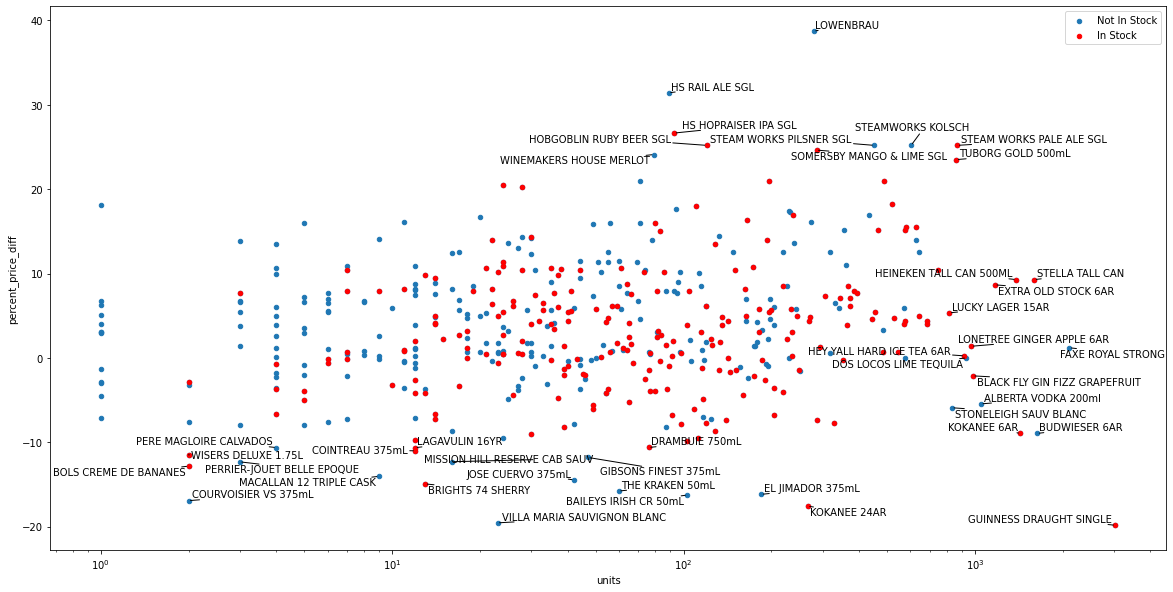

In [5]:
temp = MonthlySales[(MonthlySales['date'] >= datetime(2020,8,1)) & (MonthlySales['date'] <= datetime(2021,8,1))].groupby('upc').sum()
temp2 = pd.merge(priceComp, temp[['units']], how = 'inner', on = 'upc')

ax = temp2.plot(kind = 'scatter', x = 'units', y = 'percent_price_diff', logx = True, label = 'Not In Stock')
temp2[temp2['instock'] == True].plot(kind = 'scatter', x = 'units', y = 'percent_price_diff', logx = True, color = 'red', ax = ax, label = 'In Stock')


text = []
for index, txt in temp2[(temp2['units'] > 750) | (temp2['percent_price_diff'] < -10) | (temp2['percent_price_diff'] > 23)]['name'].iteritems():
    text.append(plt.annotate(txt,(temp2['units'][index] ,temp2['percent_price_diff'][index])))

adjust_text(text, arrowprops=dict(arrowstyle='-', color='black'))

print('Correlation = ' + str(np.corrcoef(x = temp2['units'],y = temp2['percent_price_diff'])[0,1]))
print('In stock Correlation = ' + str(np.corrcoef(x = temp2[temp2['instock'] == True]['units'],y = temp2[temp2['instock'] == True]['percent_price_diff'])[0,1]))
                                                                                        

Checking the Coorelation between the sales data and the price difference we see no relationship. This suggests we can raise some of our prices to match or exceed the government price without impacting sales. Guinness single cans are so cheap because we have a deal with kevin to give him staff price if he purchases a flat at a time. We risk losing his business to the government if we raise the price of guinness. When raising the prices we need to be careful we don't anger habitual customers that have the price memorized.

The store has seen a huge increase in volume since expanding in 2018 and again during the coronavirus pandemic.

Text(0.5, 1.0, 'Rolling Yearly Sales')

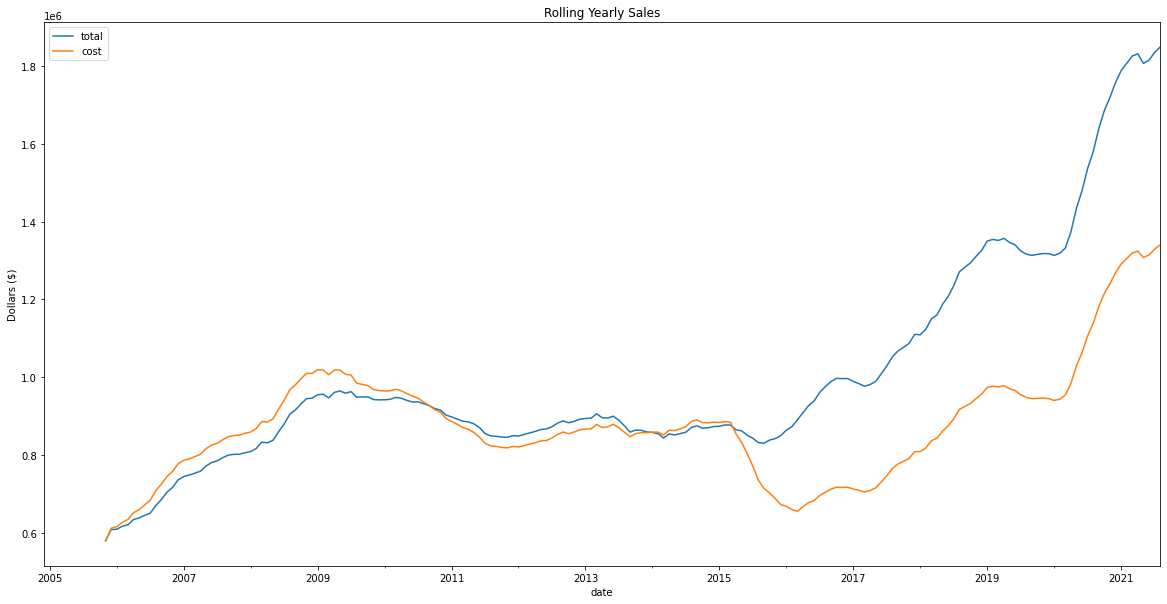

In [6]:
YearlyTotals = MonthlyTotals.rolling(window = 12 ).sum()
YearlyTotals.plot(y = ['total','cost'])
plt.ylabel('Dollars ($)')
plt.title('Rolling Yearly Sales')

Text(0.5, 1.0, 'Monthly Sales')

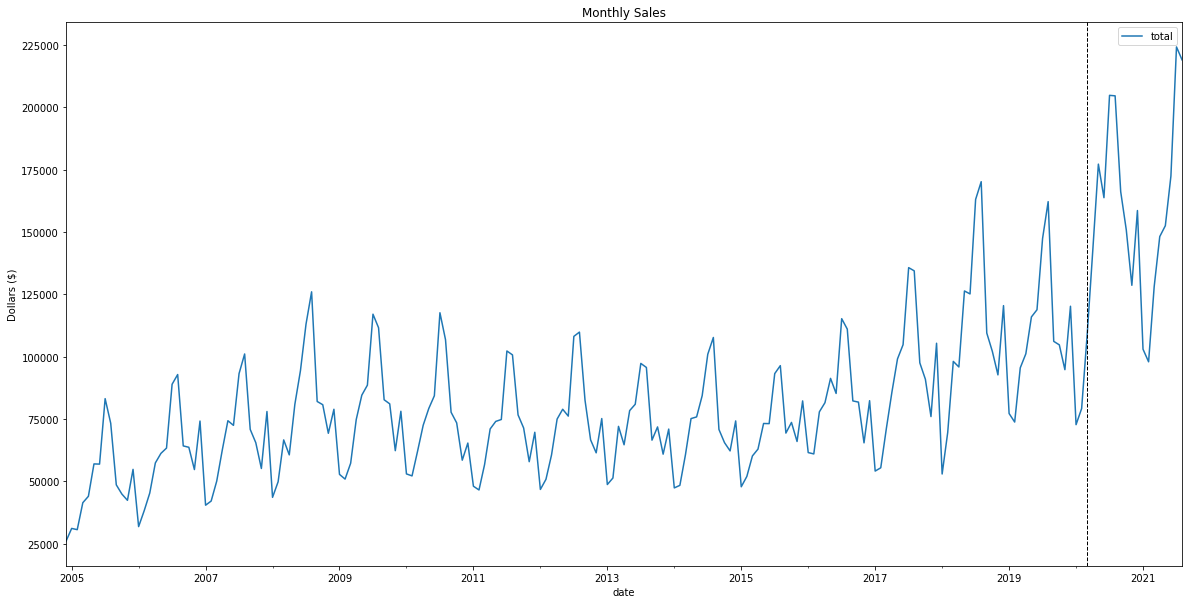

In [7]:
ax = MonthlyTotals.plot(y = 'total')
ax.axvline(x=datetime(2020,3,1),color = 'k', linestyle = '--',lw = 1)
plt.ylabel('Dollars ($)')
plt.title('Monthly Sales')


(12784.0, 18840.0)

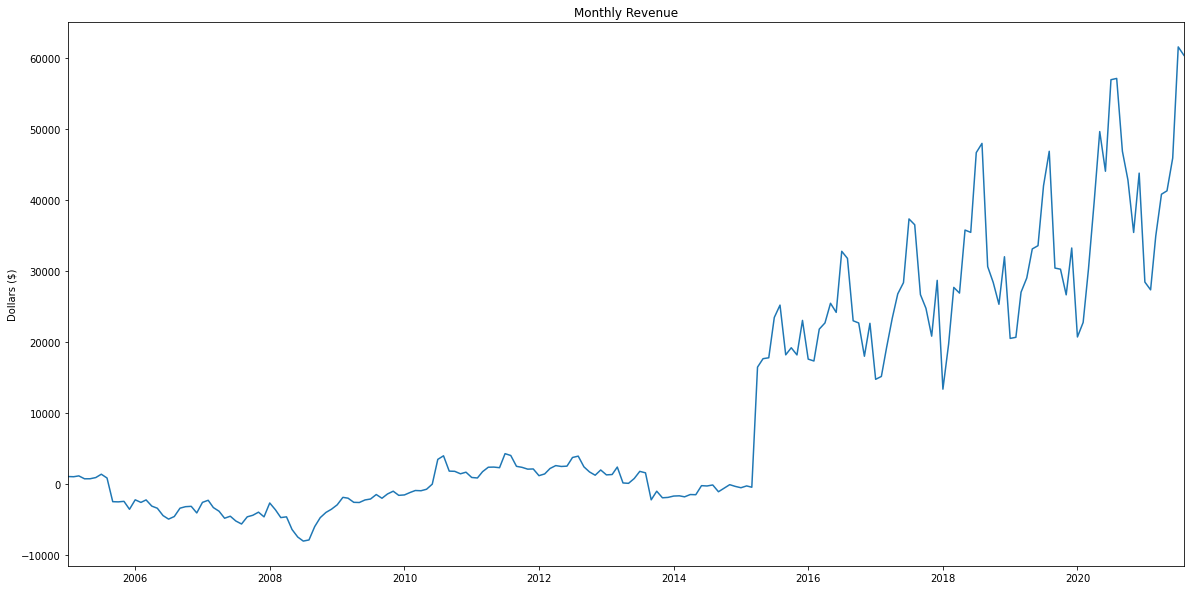

In [8]:
xmin = datetime(2005,1,1)
xmax = datetime(2021,8,1)
plt.plot(MonthlyTotals.index, MonthlyTotals['total']-MonthlyTotals['cost'])
plt.ylabel('Dollars ($)')
plt.title('Monthly Revenue')
plt.xlim(xmin,xmax)

Here you can see the effect of a change in government policy on the stores profits. Prior to 2015 private liquor stores had to buy products at the government store price, to remain competitive items were sold at cost. Only products purchased direct from supplier were profitable. I'm still convinced there is a problem with the data because the store lost 7884 by selling 133854 dollars of product for 125969 but I couldn't find any obvious errors and the manager and owner confirmed the store operate at a loss. 

To further explore this lets look at the store's profit margin. Currently the store is pretty stable around 40% with some spikes that represent the store's christmas and father's day sales.

Text(0.5, 1.0, 'Profit Margin')

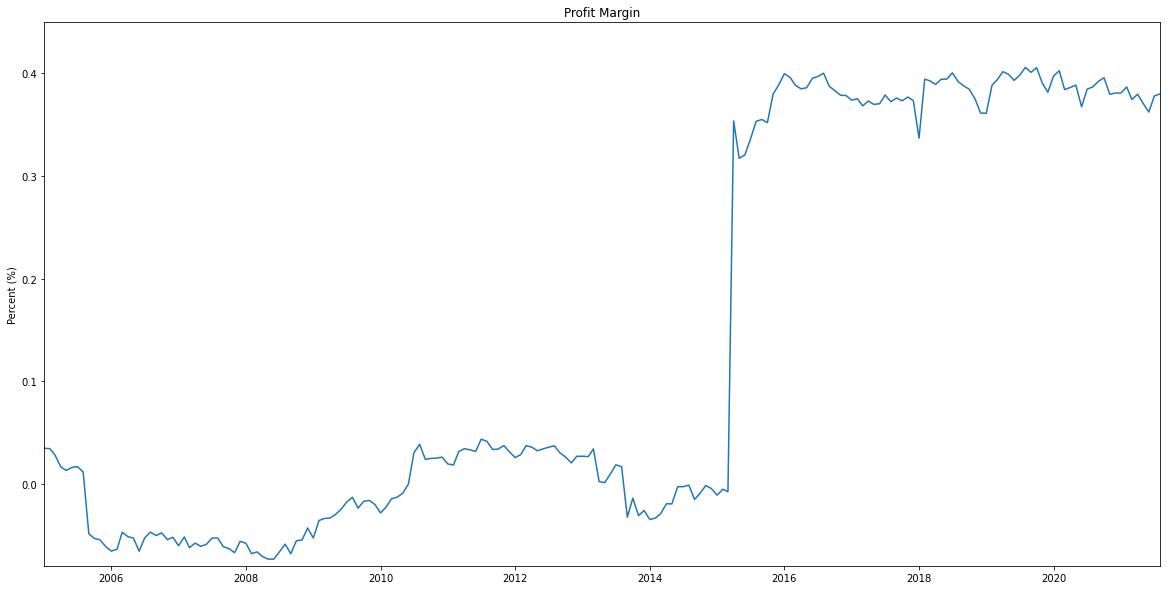

In [9]:
xmin = datetime(2005,1,1)
xmax = datetime(2021,8,1)
plt.plot(MonthlyTotals.index,MonthlyTotals['total']/MonthlyTotals['cost']-1)
plt.xlim(xmin,xmax)
plt.ylim(-0.08,0.45)
plt.ylabel('Percent (%)')
plt.title('Profit Margin')

Zooming in on the last 5 years we see the importance of keeping up cost changes even if it only affects the price a few percent. Our average margin was 1% down over the last 12 months from the average of the 12 months prior. We sold 1.5e6 dollars of product, the 1% decrease in profit margin translates to 15000 in lost profit. Thats not huge but it highlights the importance of keeping up with changes in cost and passing that cost along to the consumer. This is especially important considering current inflation rates and the consumer's inflation expectations making them more accepting of price increases.

Text(0.5, 1.0, 'Profit Margin')

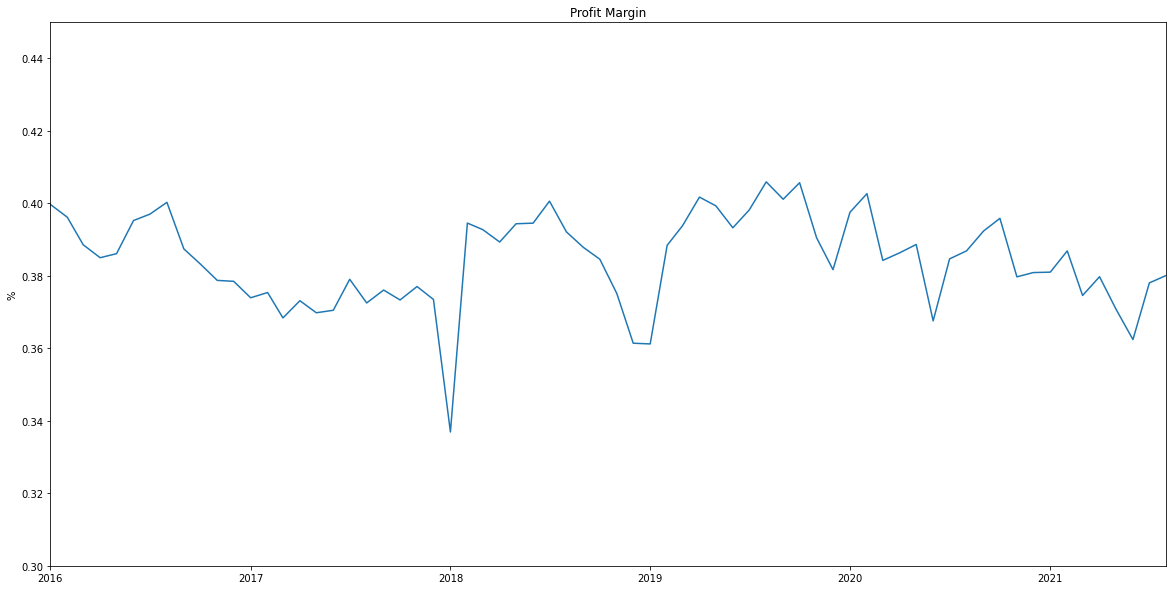

In [10]:
xmin = datetime(2016,1,1)
xmax = datetime(2021,8,1)
plt.plot(MonthlyTotals.index,MonthlyTotals['total']/MonthlyTotals['cost']-1)
plt.xlim(xmin,xmax)
plt.ylim(0.30,0.45)
plt.ylabel('%')
plt.title('Profit Margin')

Text(0, 0.5, 'Dollars ($)')

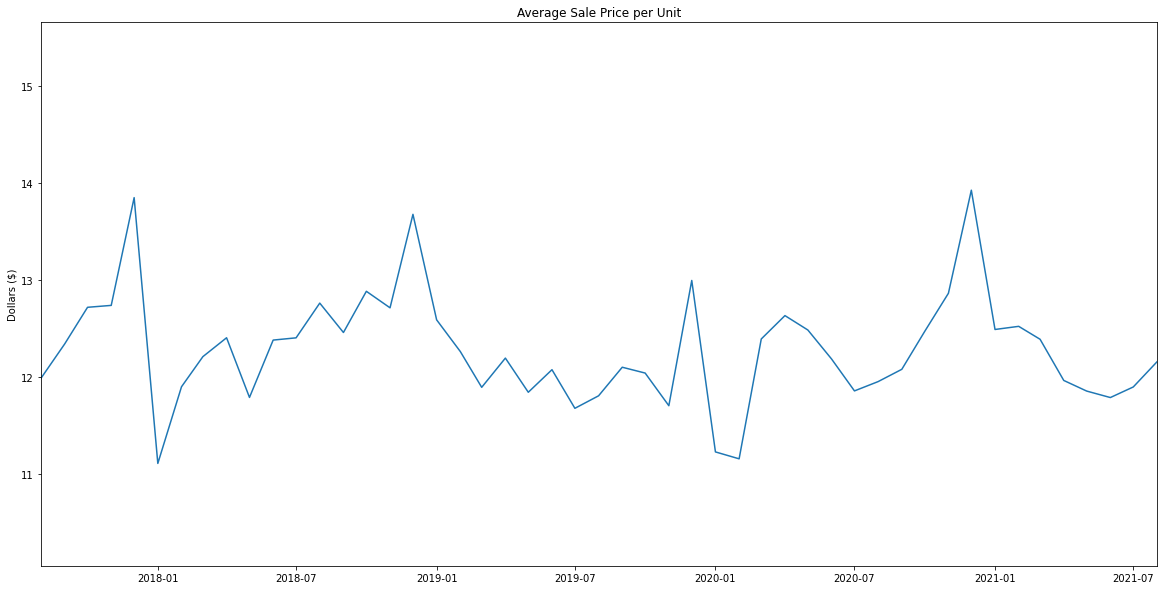

In [11]:
xmin = datetime(2017,8,1)
xmax = datetime(2021,8,1)
plt.plot(MonthlyTotals.index,MonthlyTotals['total']/MonthlyTotals['units'])
plt.xlim(xmin,xmax)
plt.title('Average Sale Price per Unit')
plt.ylabel('Dollars ($)')

#distribution plot of unit sale price in december 2020 vs jan 2021

(0.0, 200.0)

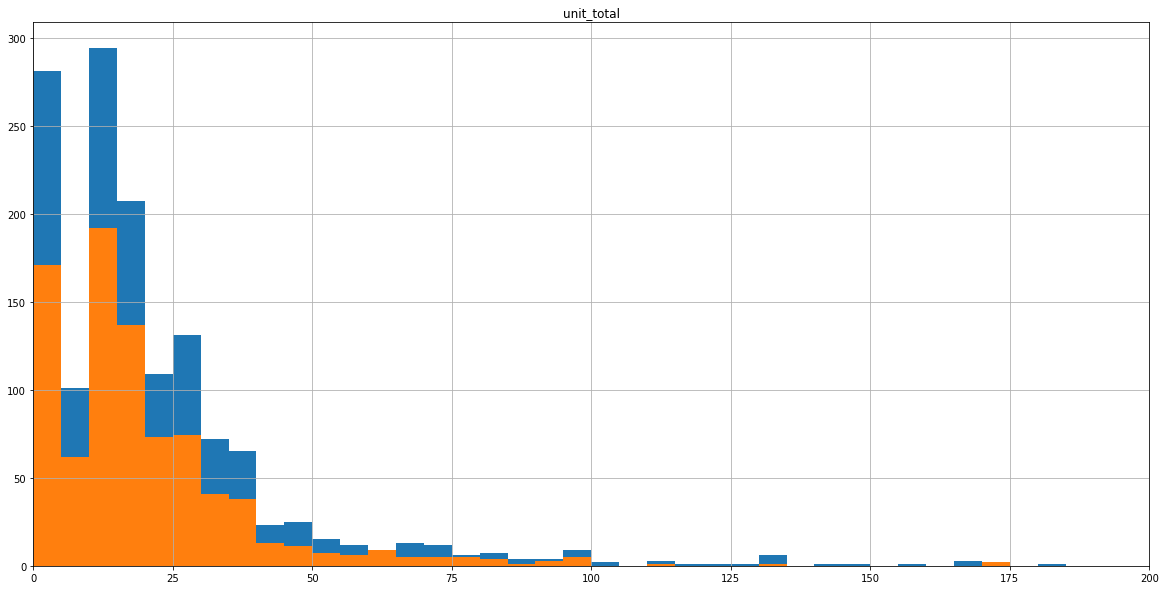

In [12]:
MonthlySales['unit_total'] = MonthlySales['total']/MonthlySales['units']

ax = MonthlySales[MonthlySales['date'] == datetime(2020,12,1)].hist(column = 'unit_total',bins = np.arange(0,200,5))
MonthlySales[MonthlySales['date'] == datetime(2021,1,1)].hist(column = 'unit_total',bins = np.arange(0,200,5), ax = ax)
plt.xlim((0,200))


(17.0, 45.0)

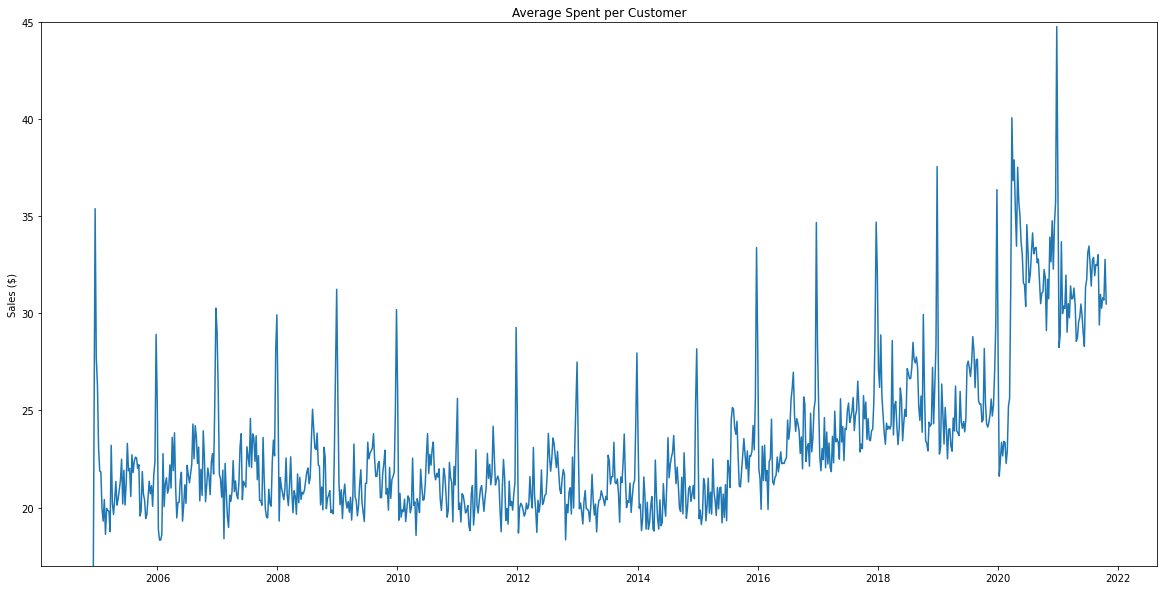

In [13]:
WeeklyCustomers = HourlyData.groupby('date').sum()
plt.plot(WeeklyCustomers.index,WeeklyCustomers.rolling(window = 1).mean()['sales']/WeeklyCustomers.rolling(window = 1).mean()['customers'])
plt.ylabel('Sales ($)')
plt.title('Average Spent per Customer')
plt.ylim(17,45)

Text(0.5, 1.0, 'Average Weekly Customers')

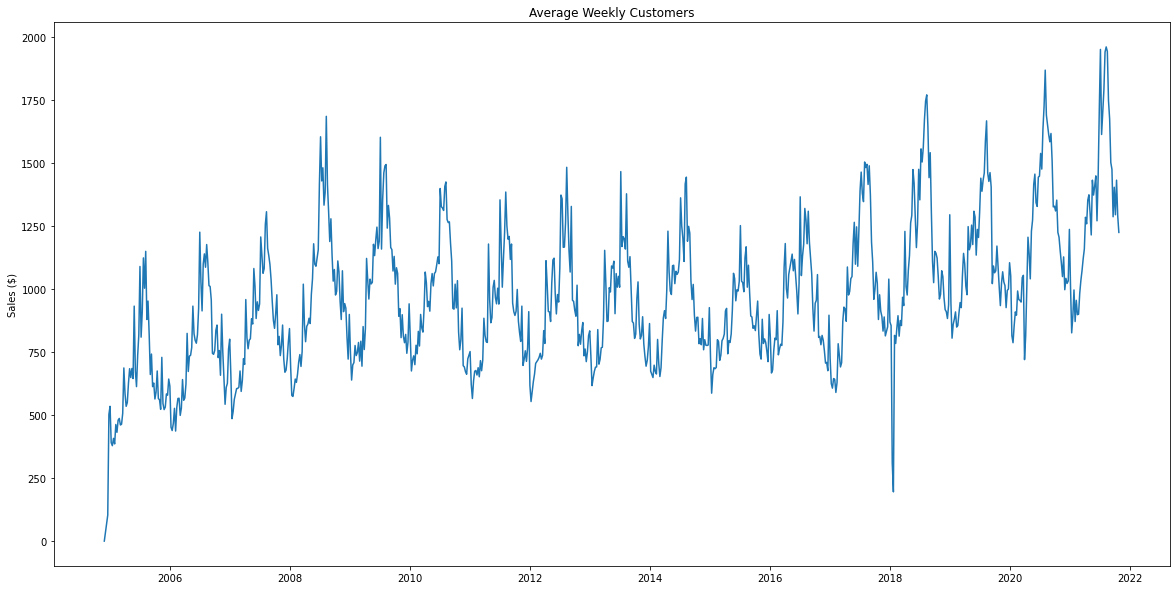

In [14]:
plt.plot(WeeklyCustomers.index,WeeklyCustomers.rolling(window = 1).mean()['customers'])
plt.ylabel('Sales ($)')
plt.title('Average Weekly Customers')

(700.0, 2000.0)

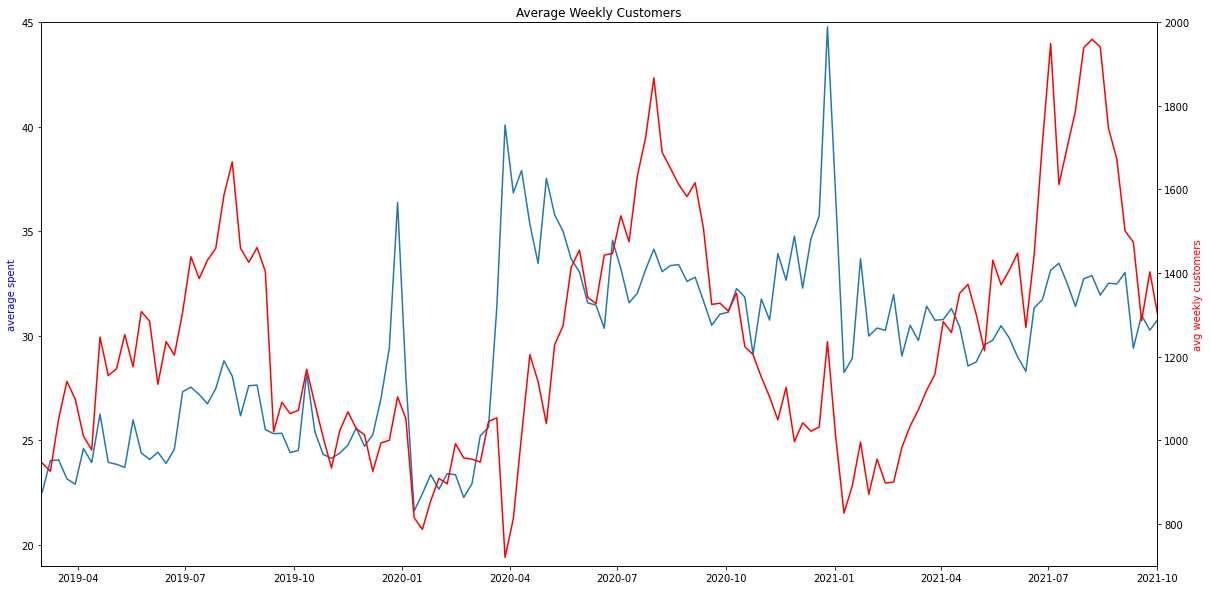

In [15]:
fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(WeeklyCustomers.index,WeeklyCustomers.rolling(window = 1).mean()['sales']/WeeklyCustomers.rolling(window = 1).mean()['customers'], label = 'average spent')
ax2.plot(WeeklyCustomers.index,WeeklyCustomers.rolling(window = 1).mean()['customers'], color = 'red', label = 'customers')
ax.set_ylabel('average spent', color = 'blue')
ax2.set_ylabel('avg weekly customers', color = 'red')
plt.title('Average Weekly Customers')
plt.xlim(datetime(2019,3,1),datetime(2021,10,1))
ax.set_ylim(19,45)
ax2.set_ylim(700,2000)

"\nI checked the hourly sales by day of week and found no change.\ntemp = rawHour[(rawHour['date_range'] == ''D'') & (rawHour['type'] == 'transactions')]\ntemp['week_day'] = temp['date'].dt.dayofweek\ntemp2 = temp[(temp['date'] > datetime(2020,10,1)) & (temp['date'] < datetime(2021,3,1))].groupby(by = ['hour', 'week_day']).mean()\nax = temp2.loc[[10,21,22],:].plot(kind = 'bar', y = ['sales'])\n"

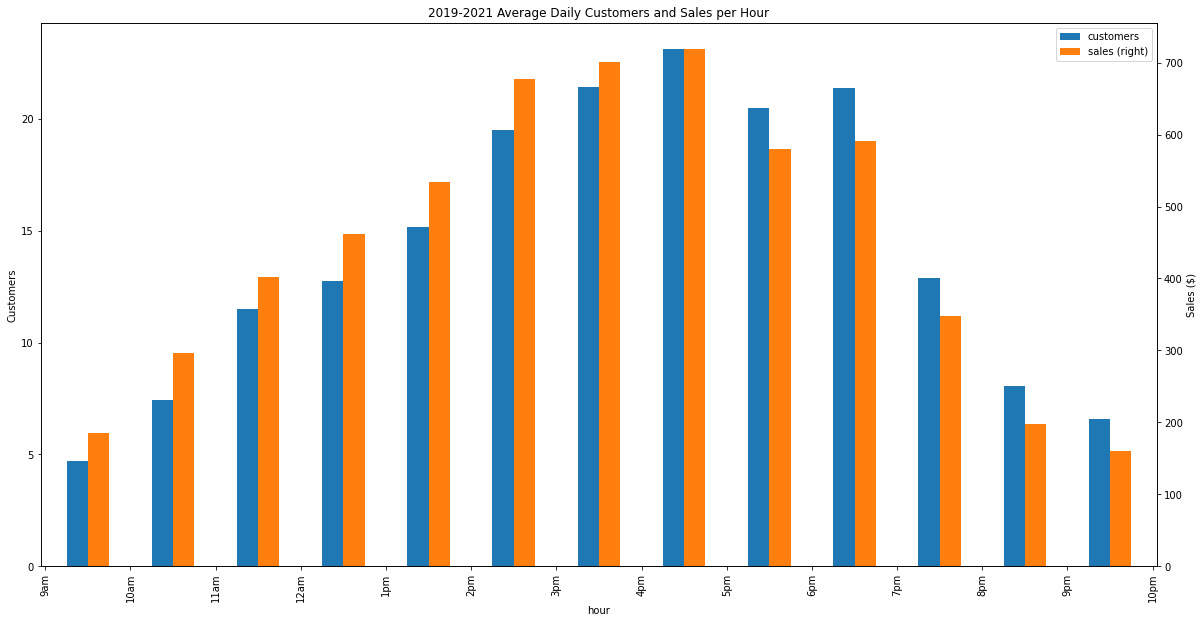

In [16]:
HourlyTotals = HourlyData[HourlyData['date'] > datetime(2020,10,1)].groupby('hour').mean()/7

ax = HourlyTotals.plot(kind = 'bar', y=['customers','sales'], secondary_y = 'sales')
ax.set_ylabel('Customers')
ax.right_ax.set_ylabel('Sales ($)')
ax.set_xticks(np.arange(0.5,14.5,1))
ax.set_xticklabels(['9am', '10am', '11am', '12am', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm','9pm', '10pm'])
ax.set_xlim(0.45,13.55)
plt.title('2019-2021 Average Daily Customers and Sales per Hour')

"""
I checked the hourly sales by day of week and found no change.
temp = rawHour[(rawHour['date_range'] == '\'D\'') & (rawHour['type'] == 'transactions')]
temp['week_day'] = temp['date'].dt.dayofweek
temp2 = temp[(temp['date'] > datetime(2020,10,1)) & (temp['date'] < datetime(2021,3,1))].groupby(by = ['hour', 'week_day']).mean()
ax = temp2.loc[[10,21,22],:].plot(kind = 'bar', y = ['sales'])
"""

(17897.0, 18932.0)

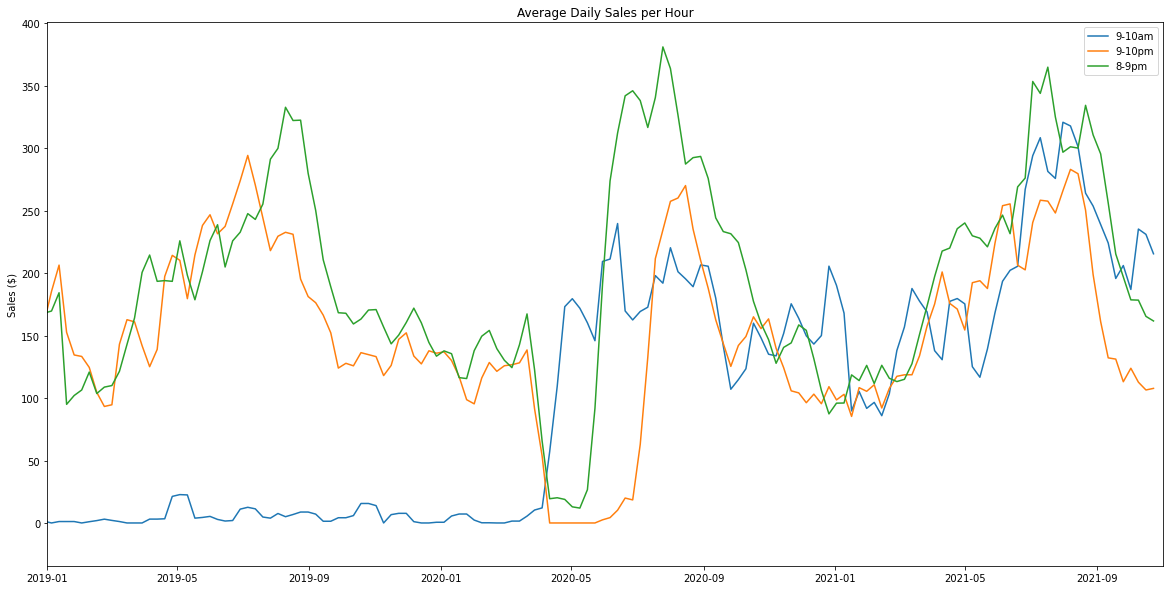

In [17]:
plt.plot(HourlySales.index,HourlySales.rolling(window = 3).mean()[10]/7,label = '9-10am')
plt.plot(HourlySales.index,HourlySales.rolling(window = 3).mean()[22]/7,label = '9-10pm')
plt.plot(HourlySales.index,HourlySales.rolling(window = 3).mean()[21]/7,label = '8-9pm')
plt.legend()
plt.ylabel('Sales ($)')
plt.title('Average Daily Sales per Hour')
plt.xlim(datetime(2019,1,1),datetime(2021,11,1))

(17897.0, 18932.0)

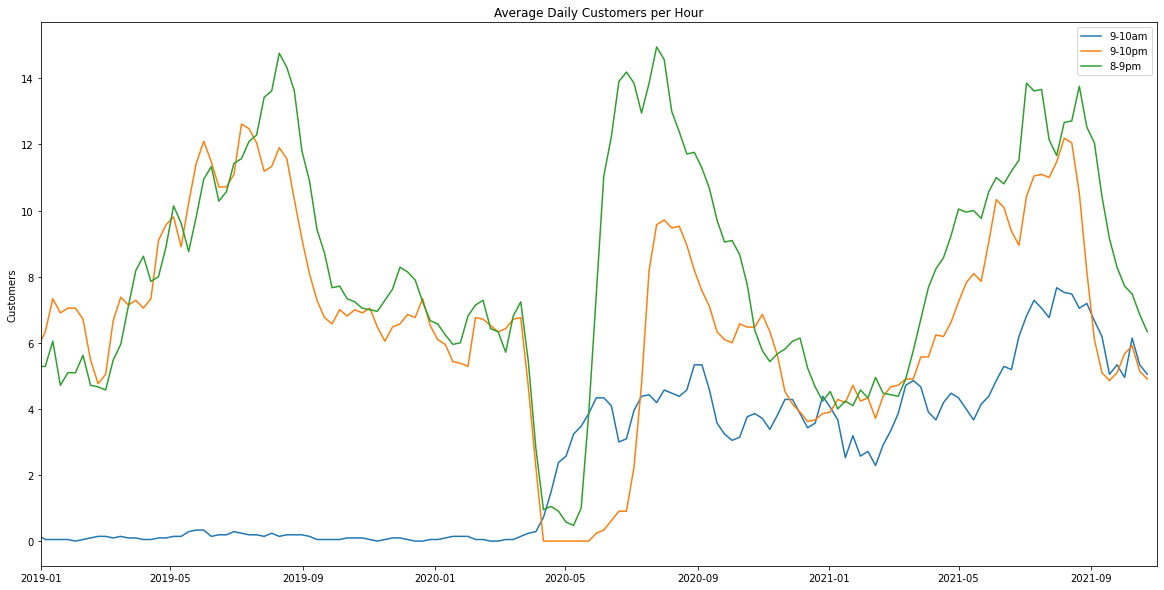

In [18]:
plt.plot(HourlyCustomers.index,HourlyCustomers.rolling(window = 3).mean()[10]/7,label = '9-10am')
plt.plot(HourlyCustomers.index,HourlyCustomers.rolling(window = 3).mean()[22]/7,label = '9-10pm')
plt.plot(HourlyCustomers.index,HourlyCustomers.rolling(window = 3).mean()[21]/7,label = '8-9pm')
plt.legend()
plt.ylabel('Customers')
plt.title('Average Daily Customers per Hour')
plt.xlim(datetime(2019,1,1),datetime(2021,11,1))

<AxesSubplot:title={'center':'Guinness Sales'}, xlabel='date', ylabel='Units'>

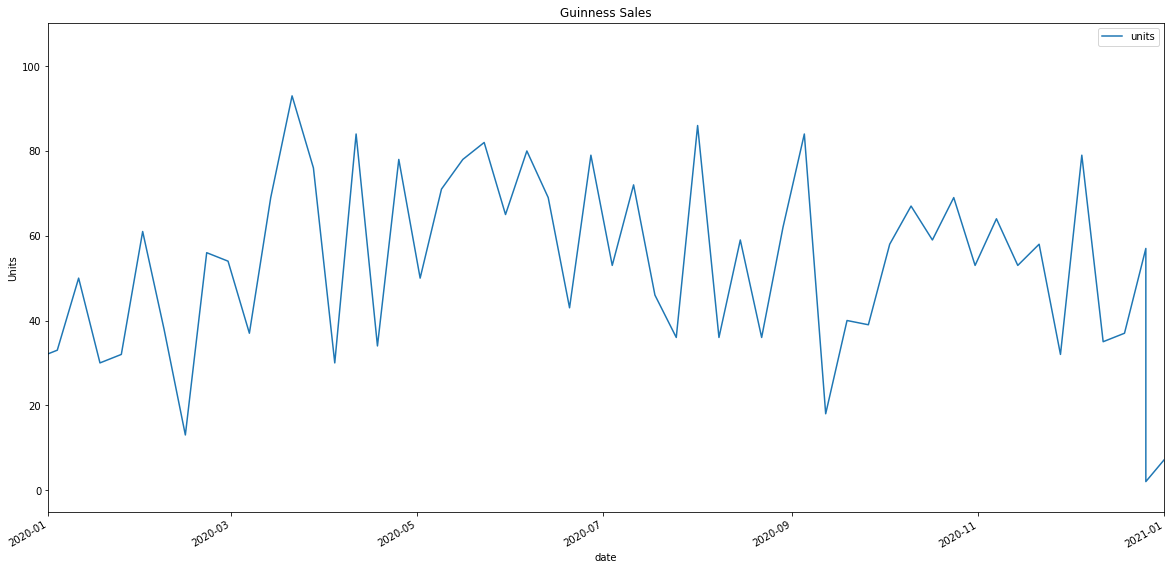

In [19]:
WeeklySales[WeeklySales['upc'] == 5000213002834].plot(x='date',y='units',xlim = [datetime(2020,1,1),datetime(2021,1,1)],title = 'Guinness Sales',ylabel = 'Units')

(18748.0, 18932.0)

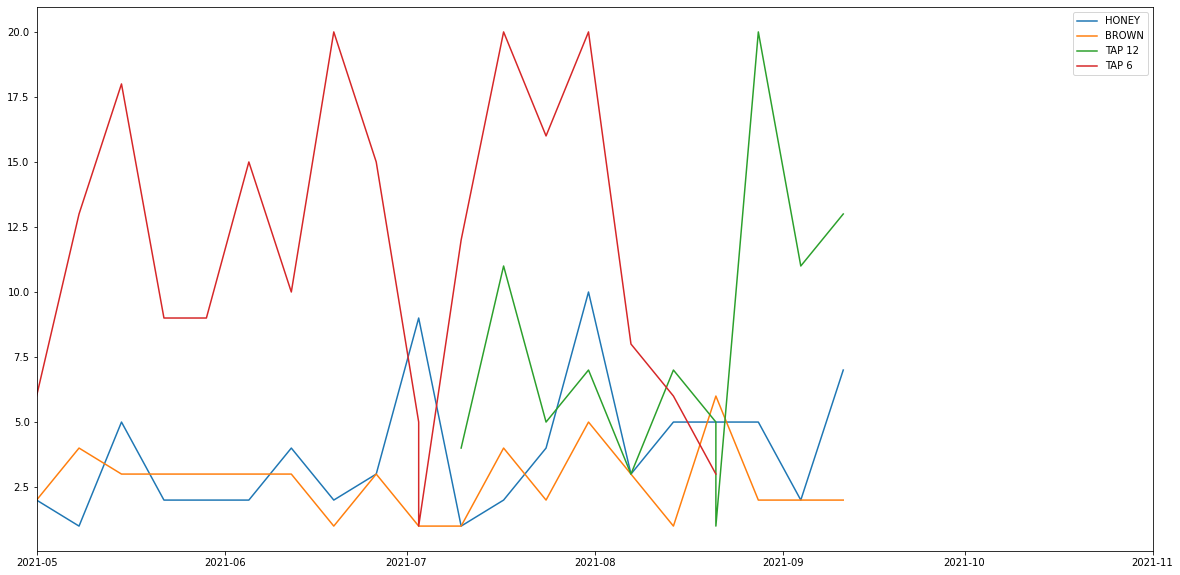

In [20]:
Px = WeeklySales[WeeklySales['name'] == 'BARNSIDE FARMERS TAP 12AR']['date']
Dx = WeeklySales[WeeklySales['name'] == 'BARNSIDE FARMERS TAP 6AR']['date']
Py = WeeklySales[WeeklySales['name'] == 'BARNSIDE FARMERS TAP 12AR'].rolling(window = 1)['units'].mean()
Dy = WeeklySales[WeeklySales['name'] == 'BARNSIDE FARMERS TAP 6AR'].rolling(window = 1)['units'].mean()
Ax = WeeklySales[WeeklySales['name'] == 'BARNSIDE HONEY COMB PALE 4AR']['date']
Sx = WeeklySales[WeeklySales['name'] == 'BARNSIDE CRESCENT ISLAND 4AR']['date']
Ay = WeeklySales[WeeklySales['name'] == 'BARNSIDE HONEY COMB PALE 4AR'].rolling(window = 1)['units'].mean()
Sy = WeeklySales[WeeklySales['name'] == 'BARNSIDE CRESCENT ISLAND 4AR'].rolling(window = 1)['units'].mean()
plt.plot(Ax,Ay, label = 'HONEY')
plt.plot(Sx,Sy, label = 'BROWN')
plt.plot(Px,Py,label = 'TAP 12')
plt.plot(Dx,Dy, label = 'TAP 6')
#plt.locator_params(axis='x', nbins=5)
plt.legend()
plt.xlim(datetime(2021,5,1),datetime(2021,11,1))

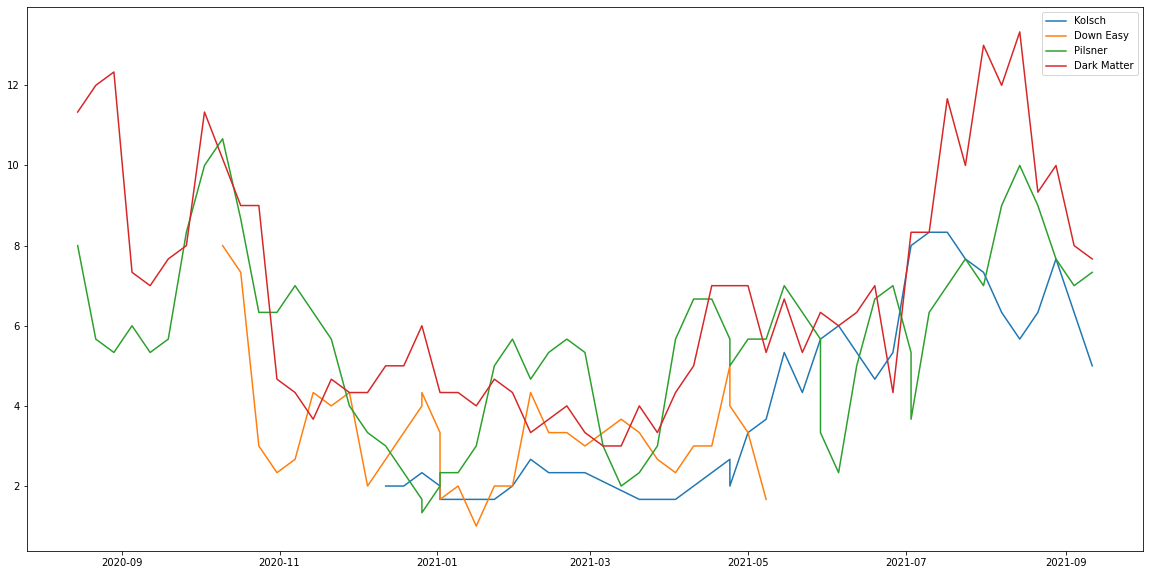

In [21]:
Px = WeeklySales[WeeklySales['name'] == 'HOYNE PILSNER 6AR']['date']
Dx = WeeklySales[WeeklySales['name'] == 'HOYNE DARK MATTER 6AR']['date']
Py = WeeklySales[WeeklySales['name'] == 'HOYNE PILSNER 6AR'].rolling(window = 3)['units'].mean()
Dy = WeeklySales[WeeklySales['name'] == 'HOYNE DARK MATTER 6AR'].rolling(window = 3)['units'].mean()
Ax = WeeklySales[WeeklySales['name'] == 'HOYNE BIER GARTEN KOLSCH 6AR']['date']
Sx = WeeklySales[WeeklySales['name'] == 'HOYNE DOWN EASY 6AR']['date']
Ay = WeeklySales[WeeklySales['name'] == 'HOYNE BIER GARTEN KOLSCH 6AR'].rolling(window = 3)['units'].mean()
Sy = WeeklySales[WeeklySales['name'] == 'HOYNE DOWN EASY 6AR'].rolling(window = 3)['units'].mean()
plt.plot(Ax,Ay, label = 'Kolsch')
plt.plot(Sx,Sy, label = 'Down Easy')
plt.plot(Px,Py,label = 'Pilsner')
plt.plot(Dx,Dy, label = 'Dark Matter')
#plt.locator_params(axis='x', nbins=5)
plt.legend()

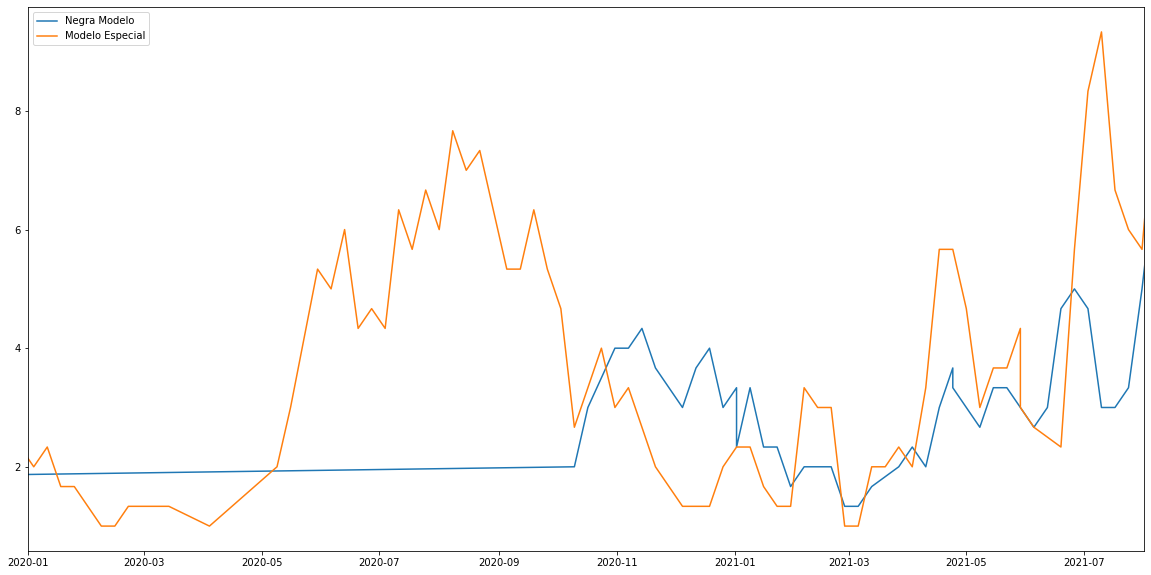

In [22]:
Px = WeeklySales[WeeklySales['name'] == 'NEGRA MODELO 6PB']['date']
Dx = WeeklySales[WeeklySales['name'] == 'MODELO ESPECIAL 6PB']['date']
Py = WeeklySales[WeeklySales['name'] == 'NEGRA MODELO 6PB'].rolling(window = 3)['units'].mean()
Dy = WeeklySales[WeeklySales['name'] == 'MODELO ESPECIAL 6PB'].rolling(window = 3)['units'].mean()
plt.plot(Px,Py,label = 'Negra Modelo')
plt.plot(Dx,Dy, label = 'Modelo Especial')
plt.xlim(datetime(2020,1,1),datetime(2021,8,1))
plt.legend()

In [23]:
def plotter(products,coarsen,xmin):
    for product in products:
        x = WeeklySales[WeeklySales['name'] == product]['date']
        y = WeeklySales[WeeklySales['name'] == product].rolling(window = coarsen)['units'].mean()
        plt.plot(x,y, label = product)
        plt.xlim(left = xmin)
    plt.legend()

In [24]:
def bar(products,xmin,xmax):
    y = WeeklySales[products & (WeeklySales['date'] >= xmin) & (WeeklySales['date'] <= xmax)]
    y = y.groupby('name').mean().sort_values(by = 'units', ascending = False)
    plt.bar(y.index,y['units'])
    plt.legend()

In [25]:
WeeklySales[WeeklySales['name'].str.contains('C12 S')]

upc       date  price_level    cost  units   total  unit_cost  \
204592  66170650302 2021-07-17            0  33.300     12   49.96      2.775   
204593  66170650302 2021-07-24            0  58.275     21   88.30      2.775   
204594  66170650302 2021-07-31            0  88.800     32  135.16      2.775   
204595  66170650302 2021-08-07            0  38.850     14   59.64      2.775   
204596  66170650302 2021-08-14            0  41.625     15   63.90      2.775   
204597  66170650302 2021-08-21            0  13.875      5   20.14      2.775   
204598  66170650302 2021-08-21            0   2.775      1    4.26      2.775   
204599  66170650302 2021-08-28            0  16.650      6   25.56      2.775   
204600  66170650302 2021-09-04            0  33.300     12   51.12      2.775   
204601  66170650302 2021-09-11            0  36.075     13   53.06      2.775   

        unit_total                    name modification_date  \
204592    4.163333  C12 STONE FRUIT SAISON         2021196.0   
204593    4.204762  C12 STONE FRUIT SAISON         2021196.0   
204594    4.223750  C12 STONE FRUIT SAISON         2021196.0   
204595    4.260000  C12 STONE FRUIT SAISON         2021196.0   
204596    4.260000  C12 STONE FRUIT SAISON         2021196.0   
204597    4.028000  C12 STONE FRUIT SAISON         2021196.0   
204598    4.260000  C12 STONE FRUIT SAISON         2021196.0   
204599    4.260000  C12 STONE FRUIT SAISON         2021196.0   
204600    4.260000  C12 STONE FRUIT SAISON         2021196.0   
204601    4.081538  C12 STONE FRUIT SAISON         2021196.0   

                       category  
204592  Single Beer Fridge Door  
204593  Single Beer Fridge Door  
204594  Single Beer Fridge Door  
204595  Single Beer Fridge Door  
204596  Single Beer Fridge Door  
204597  Single Beer Fridge Door  
204598  Single Beer Fridge Door  
204599  Single Beer Fridge Door  
204600  Single Beer Fridge Door  
204601  Single Beer Fridge Door

Text(0.5, 1.0, 'Average Weekly Sales')

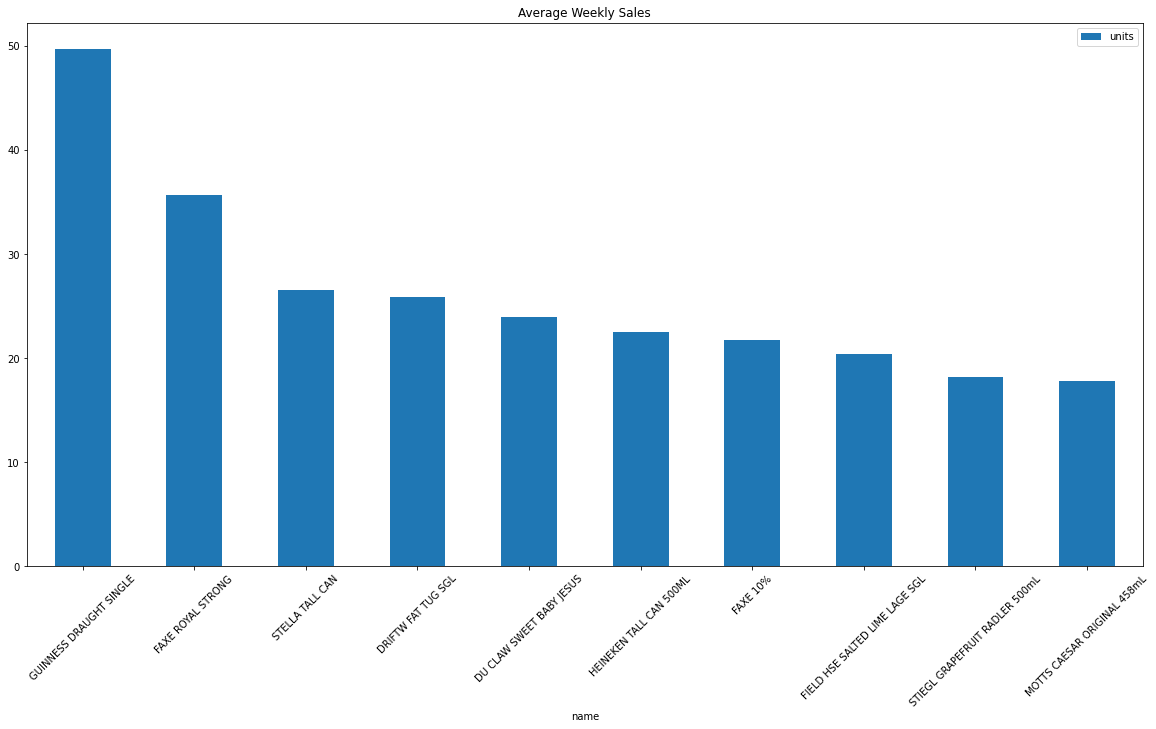

In [26]:
def bar2(products,xmin,xmax):
    WeeklySales[products & (WeeklySales['date'] >= xmin) & (WeeklySales['date'] <= xmax)].groupby('name').mean().sort_values(by = 'units', ascending = False)[:10].plot.bar(y='units')
    plt.legend()
    

bar2(WeeklySales['category'] == 'Single Beer Fridge Door', datetime(2020,8,1),datetime(2021,10,1))
plt.xticks(rotation = 45)
plt.title('Average Weekly Sales')

Text(0.5, 1.0, 'Average Weekly Sales')

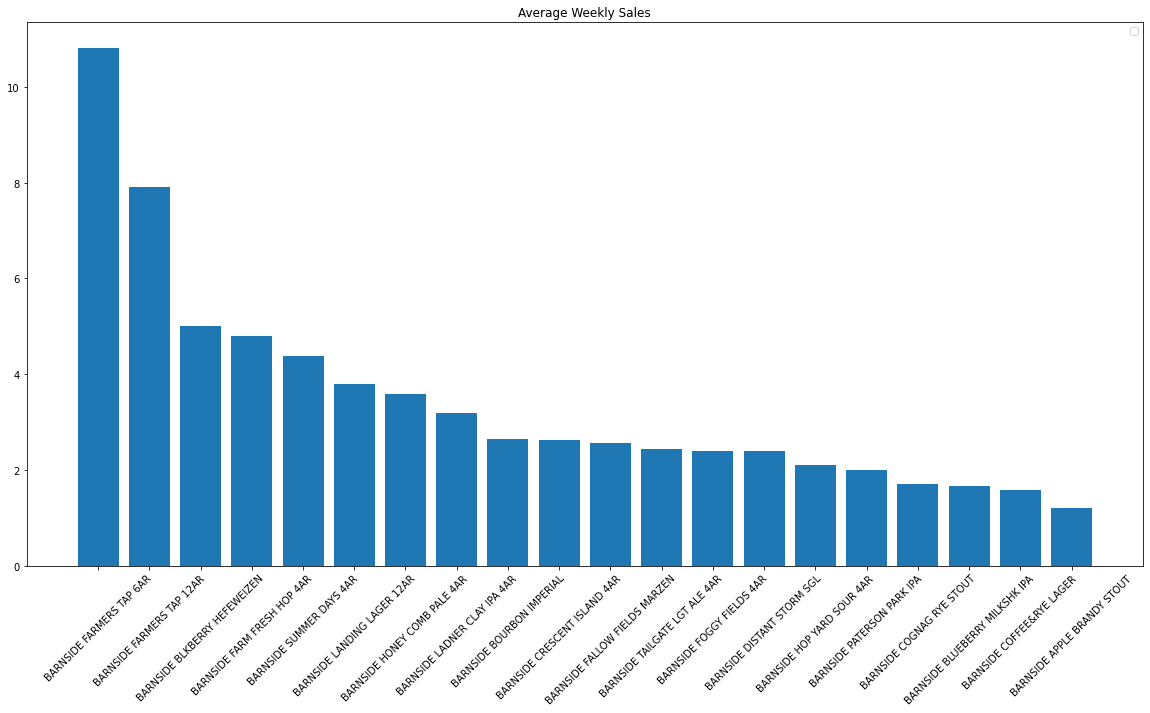

In [27]:
bar(WeeklySales['name'].str.contains('BARNSIDE'), datetime(2020,8,1),datetime(2021,10,1))
plt.xticks(rotation = 45)
plt.title('Average Weekly Sales')

Text(0.5, 1.0, 'Average Weekly Sales')

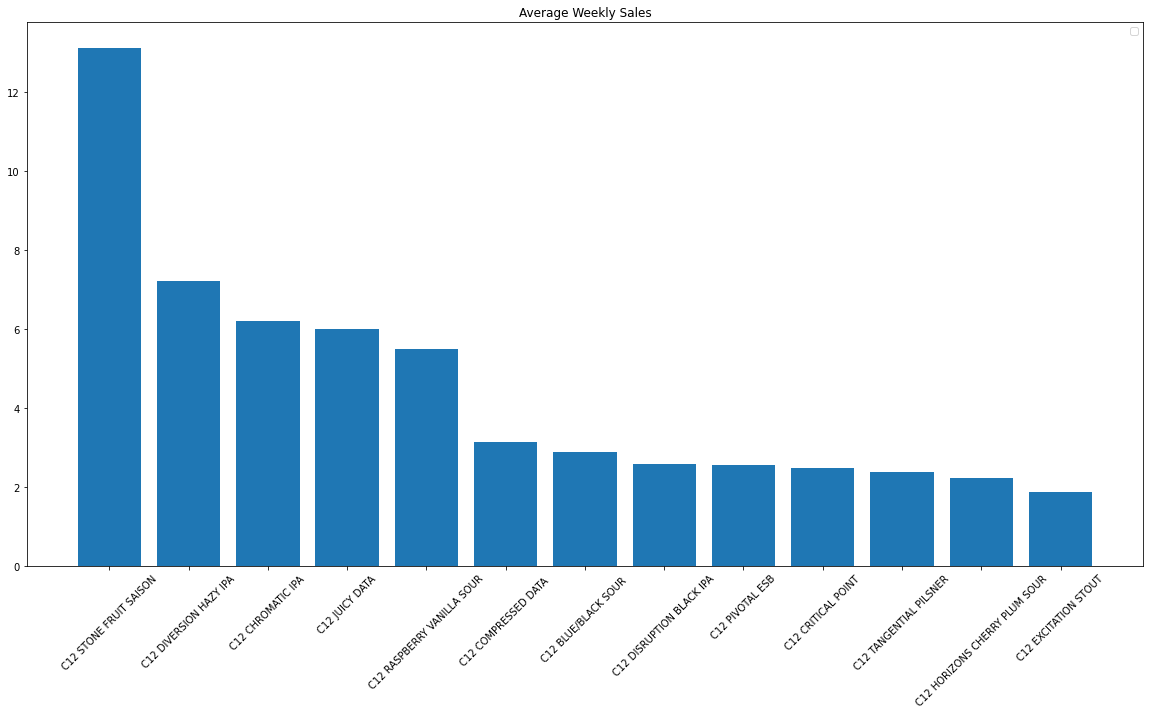

In [28]:
bar(WeeklySales['name'].str.contains('C12'), datetime(2020,8,1),datetime(2021,10,1))
plt.xticks(rotation = 45)
plt.title('Average Weekly Sales')

Text(0.5, 1.0, 'Most Popular Red Wine Over $15')

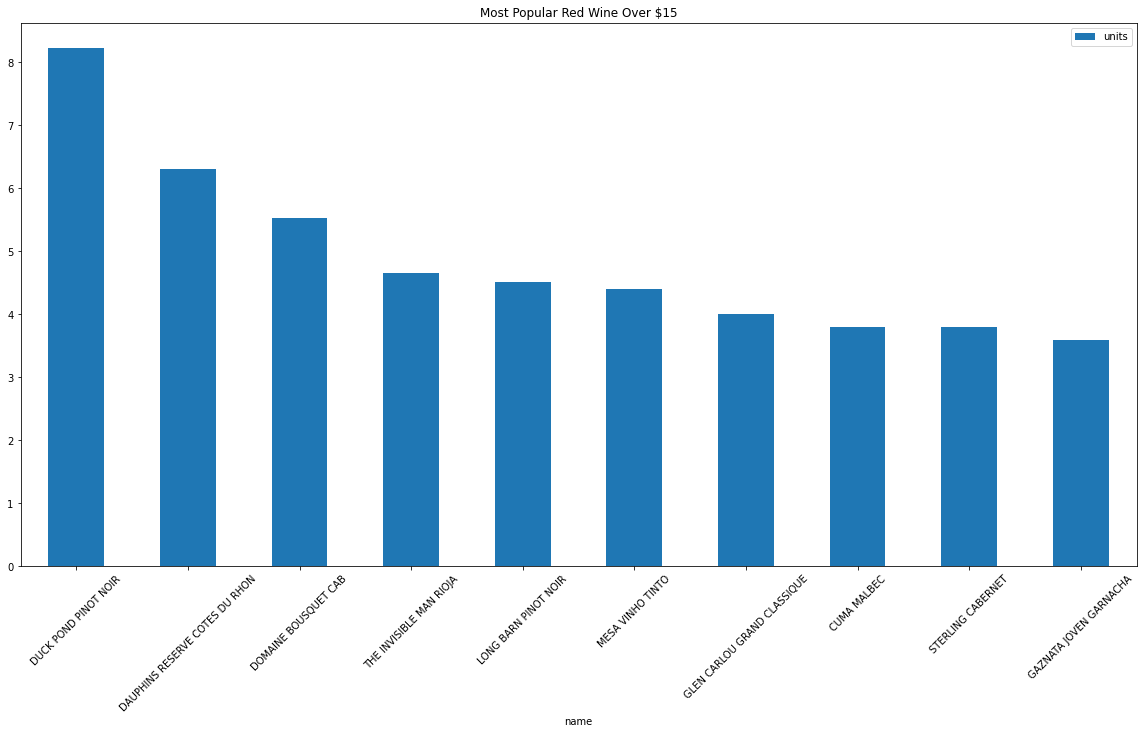

In [29]:
bar2(((WeeklySales['category'] == 'Red Wine-Domestic') | (WeeklySales['category'] == 'Red Wine-Import') )& (WeeklySales['unit_total'] > 15), datetime(2020,8,1),datetime(2021,10,1))
plt.xticks(rotation = 45)
plt.title('Most Popular Red Wine Over $15')



In [30]:
WeeklyTotals = pd.pivot_table(WeeklySales, values = ['units','cost','total'],index = ['date'],columns = ['category'], fill_value = 0, aggfunc = 'sum')


<AxesSubplot:xlabel='date'>

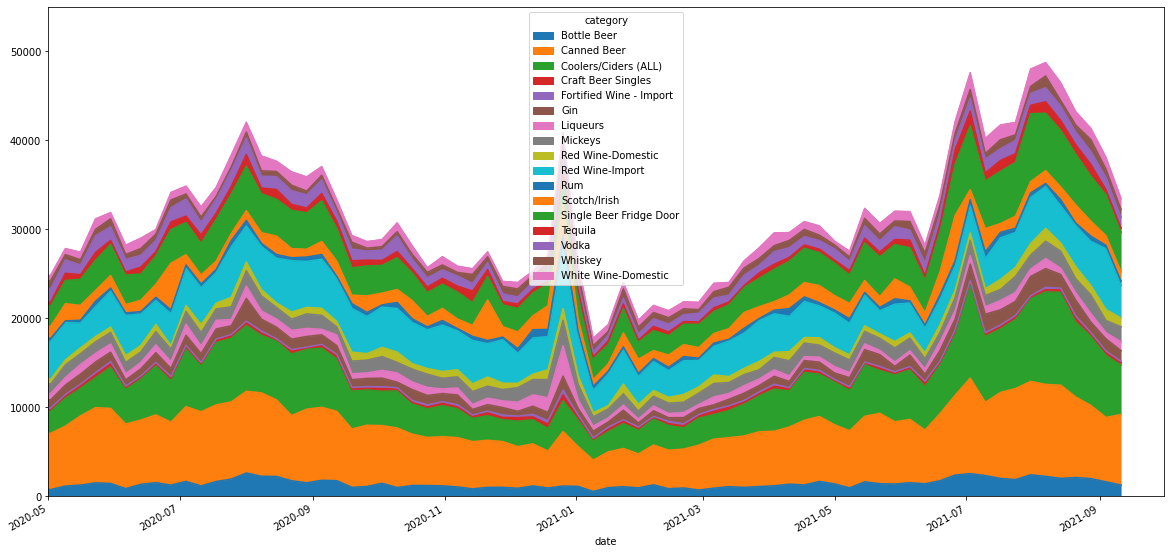

In [31]:
cats = """
'Bottle Beer', 'Brandy', 'Canned Beer', 'Coolers/Ciders (ALL)','Craft Beer Singles', 
'Fortified Wine - Import', 'Gin', 'Liqueurs','Mickeys', 'NON ALCOHOL', 'Red Wine-Domestic', 
'Red Wine-Import', 'Rum','Scotch/Irish', 'Single Beer Fridge Door', 'Sparkling Wines', 
'Tequila','Vodka', 'Whiskey', 'White Wine-Domestic', 'White Wine-Import'
"""

WeeklyTotals['total'].plot.area(y= ['Bottle Beer', 'Canned Beer', 'Coolers/Ciders (ALL)','Craft Beer Singles', 
'Fortified Wine - Import', 'Gin', 'Liqueurs','Mickeys', 'Red Wine-Domestic', 
'Red Wine-Import', 'Rum','Scotch/Irish', 'Single Beer Fridge Door', 
'Tequila','Vodka', 'Whiskey', 'White Wine-Domestic'], stacked = True, xlim = [datetime(2020,5,1),datetime(2021,10,1)], ylim = [0,55000])

In [32]:
percentTotals = WeeklyTotals['total'].div(WeeklyTotals['total'].sum(axis = 1), axis = 'rows')
percentTotals.columns

Index(['Bottle Beer', 'Brandy', 'Canned Beer', 'Coolers/Ciders (ALL)',
       'Craft Beer Singles', 'Fortified Wine - Import', 'Gin', 'Liqueurs',
       'Mickeys', 'NON ALCOHOL', 'Red Wine-Domestic', 'Red Wine-Import', 'Rum',
       'Scotch/Irish', 'Single Beer Fridge Door', 'Sparkling Wines', 'Tequila',
       'Vodka', 'Whiskey', 'White Wine-Domestic', 'White Wine-Import',
       'Wine Accessories', 'unknown'],
      dtype='object', name='category')

In [33]:
WeeklyTotals['total']

category    Bottle Beer  Brandy  Canned Beer  Coolers/Ciders (ALL)  \
date                                                                 
2004-12-18        21.07   63.84       129.51                  0.00   
2004-12-25        53.34   84.52       799.42                  0.00   
2005-01-01        42.14   84.22       909.91                  0.00   
2005-01-08         0.00   84.52       889.63                  0.00   
2005-01-15         0.00  211.30       471.95                  0.00   
...                 ...     ...          ...                   ...   
2021-08-14      2018.07   72.78     10465.01              10429.08   
2021-08-21      2116.77  147.38      9031.53               8430.83   
2021-08-28      1992.30  115.64      8212.54               7752.17   
2021-09-04      1633.61   97.04      7227.93               6985.01   
2021-09-11      1270.73   98.86      7921.33               5530.53   

category    Craft Beer Singles  Fortified Wine - Import      Gin  Liqueurs  \
date                                                                         
2004-12-18                0.00                     6.41     0.00    132.20   
2004-12-25                0.00                    69.06    51.80    348.68   
2005-01-01                0.00                    96.51   128.73    256.55   
2005-01-08                0.00                    23.34   124.36     53.88   
2005-01-15                0.00                    23.34    26.93      0.00   
...                        ...                      ...      ...       ...   
2021-08-14              272.39                   203.90  1534.38    696.01   
2021-08-21              414.57                   248.68  1793.06    802.82   
2021-08-28              249.18                   196.61  1161.08    965.46   
2021-09-04              290.35                   185.12  1368.88    687.65   
2021-09-11              290.14                   166.44  1179.23   1001.21   

category    Mickeys  NON ALCOHOL  ...  Scotch/Irish  Single Beer Fridge Door  \
date                              ...                                          
2004-12-18    72.24         0.00  ...         42.31                     8.88   
2004-12-25   493.31         0.00  ...        181.31                    39.46   
2005-01-01   403.15         0.00  ...         42.31                    76.20   
2005-01-08   317.24         0.00  ...         42.31                    59.48   
2005-01-15   327.23         0.00  ...          0.00                    43.93   
...             ...          ...  ...           ...                      ...   
2021-08-14  1922.03        84.64  ...       1430.96                  6357.36   
2021-08-21  1597.39        90.67  ...       2042.90                  5723.85   
2021-08-28  2086.04        65.94  ...       1671.82                  5074.33   
2021-09-04  1370.08        64.84  ...       1077.79                  4597.55   
2021-09-11  1687.62        58.09  ...       1071.06                  4389.48   

category    Sparkling Wines  Tequila    Vodka  Whiskey  White Wine-Domestic  \
date                                                                          
2004-12-18             0.00     0.00    63.50    87.36                 0.00   
2004-12-25            92.28     0.00   236.81   273.35                 0.00   
2005-01-01            92.28     0.00   237.74   264.56                 0.00   
2005-01-08             0.00     0.00   252.99   190.84                 0.00   
2005-01-15             0.00     0.00   159.15     0.00                 0.00   
...                     ...      ...      ...      ...                  ...   
2021-08-14           499.02  1109.26  1617.99   628.91              2001.00   
2021-08-21           990.53  1048.50  1427.92   774.74              1497.73   
2021-08-28           835.69  1307.56  1464.85  1321.14              1268.49   
2021-09-04           870.93   582.03  1372.60   918.61              1331.46   
2021-09-11           473.57   499.74  1205.15   879.62              1246.46   

categ

In [34]:
weeklyTotals2 = WeeklyTotals['total']
weeklyTotals2['wine'] = weeklyTotals2['White Wine-Domestic'] + weeklyTotals2['Fortified Wine - Import'] + weeklyTotals2['Wine Accessories'] + weeklyTotals2['Red Wine-Domestic'] + weeklyTotals2['Red Wine-Import'] + weeklyTotals2['White Wine-Import'] + weeklyTotals2['Sparkling Wines']
weeklyTotals2['spirits'] = weeklyTotals2['Brandy'] + weeklyTotals2['Gin'] + weeklyTotals2['Liqueurs'] + weeklyTotals2['Mickeys'] + weeklyTotals2['Rum'] + weeklyTotals2['Scotch/Irish'] + weeklyTotals2['Tequila'] + weeklyTotals2['Whiskey'] + weeklyTotals2['Vodka']
weeklyTotals2['beer'] = weeklyTotals2['Bottle Beer'] + weeklyTotals2['Canned Beer'] + weeklyTotals2['Craft Beer Singles']
weeklyTotals2.drop(columns = ['Bottle Beer', 'Brandy', 'Canned Beer', 'Craft Beer Singles',
'Fortified Wine - Import', 'Gin', 'Liqueurs','Mickeys', 'Red Wine-Domestic', 
'Red Wine-Import', 'Rum','Scotch/Irish', 'Sparkling Wines', 'Wine Accessories', 
'Tequila','Vodka', 'Whiskey', 'White Wine-Domestic', 'White Wine-Import'], inplace = True)
weeklyTotals2[weeklyTotals2 < 0] = 0
weeklyTotals2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

category    Coolers/Ciders (ALL)  NON ALCOHOL  Single Beer Fridge Door  \
date                                                                     
2004-12-18                   0.0          0.0                     8.88   
2004-12-25                   0.0          0.0                    39.46   
2005-01-01                   0.0          0.0                    76.20   
2005-01-08                   0.0          0.0                    59.48   
2005-01-15                   0.0          0.0                    43.93   

category    unknown    wine  spirits    beer  
date                                          
2004-12-18  2383.80   45.39   516.28  150.58  
2004-12-25  8609.19  201.33  2013.81  852.76  
2005-01-01  8700.42  278.01  1754.44  952.05  
2005-01-08  5256.16   54.09  1261.68  889.63  
2005-01-15  5379.40   33.59  1017.02  471.95

<AxesSubplot:xlabel='date'>

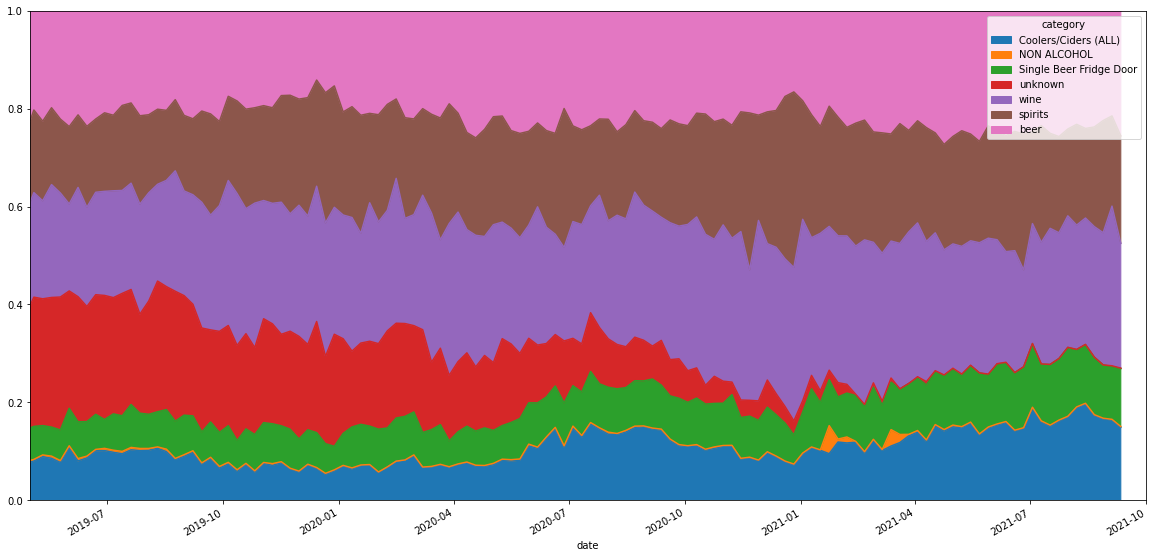

In [35]:
percentTotals = WeeklyTotals['total'].div(WeeklyTotals['total'].sum(axis = 1), axis = 'rows')
percentTotals['wine'] = percentTotals['White Wine-Domestic'] + percentTotals['Fortified Wine - Import'] + percentTotals['Wine Accessories'] + percentTotals['Red Wine-Domestic'] + percentTotals['Red Wine-Import'] + percentTotals['White Wine-Import'] + percentTotals['Sparkling Wines']
percentTotals['spirits'] = percentTotals['Brandy'] + percentTotals['Gin'] + percentTotals['Liqueurs'] + percentTotals['Mickeys'] + percentTotals['Rum'] + percentTotals['Scotch/Irish'] + percentTotals['Tequila'] + percentTotals['Whiskey'] + percentTotals['Vodka']
percentTotals['beer'] = percentTotals['Bottle Beer'] + percentTotals['Canned Beer'] + percentTotals['Craft Beer Singles']
percentTotals.drop(columns = ['Bottle Beer', 'Brandy', 'Canned Beer', 'Craft Beer Singles',
'Fortified Wine - Import', 'Gin', 'Liqueurs','Mickeys', 'Red Wine-Domestic', 
'Red Wine-Import', 'Rum','Scotch/Irish', 'Sparkling Wines', 'Wine Accessories', 
'Tequila','Vodka', 'Whiskey', 'White Wine-Domestic', 'White Wine-Import'], inplace = True)
percentTotals[percentTotals < 0] = 0
percentTotals.plot.area( stacked = True, xlim = [datetime(2019,5,1),datetime(2021,10,1)], ylim = [0,1])
#WeeklyTotals['total'].div(WeeklyTotals['total'].sum(axis = 1), axis = 'rows').rolling(window = 3).mean().plot(y = ['Vodka','Whiskey','Rum', 'Mickeys', 'Tequila','Canned Beer'], xlim = (datetime(2019,1,1),datetime(2021,10,1)), ylim = (0,0.07))
#plt.plot(np.full(len(np.arange(0,100000)),datetime(2020,3,1)),np.arange(0,100000))

<AxesSubplot:xlabel='date'>

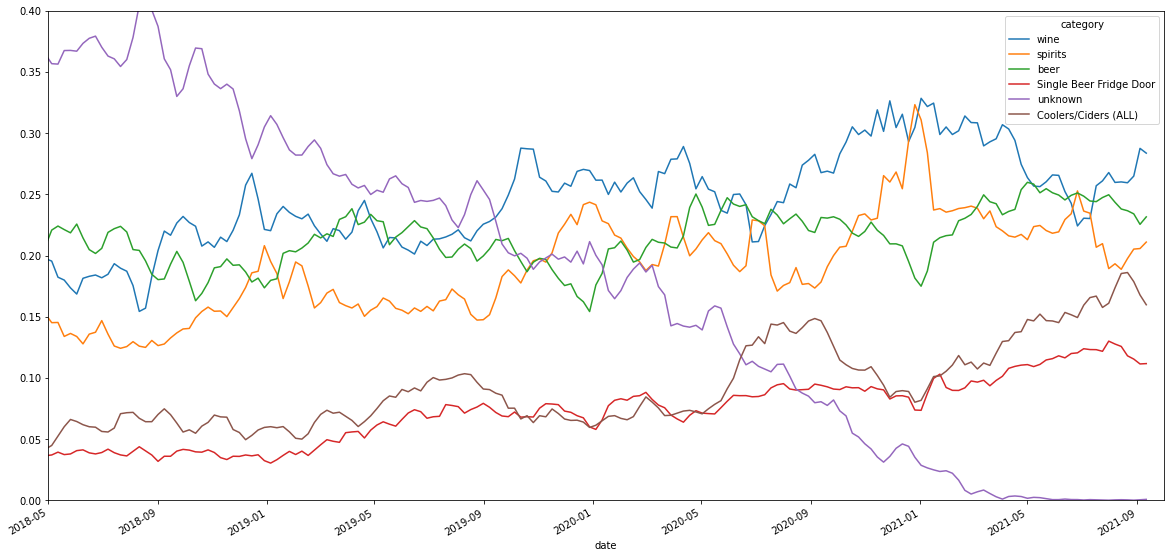

In [36]:
percentTotals.rolling(window = 3).mean().plot(y = ['wine', 'spirits', 'beer', 'Single Beer Fridge Door', 'unknown', 'Coolers/Ciders (ALL)'], xlim = [datetime(2018,5,1),datetime(2021,10,1)], ylim = [0,0.4])

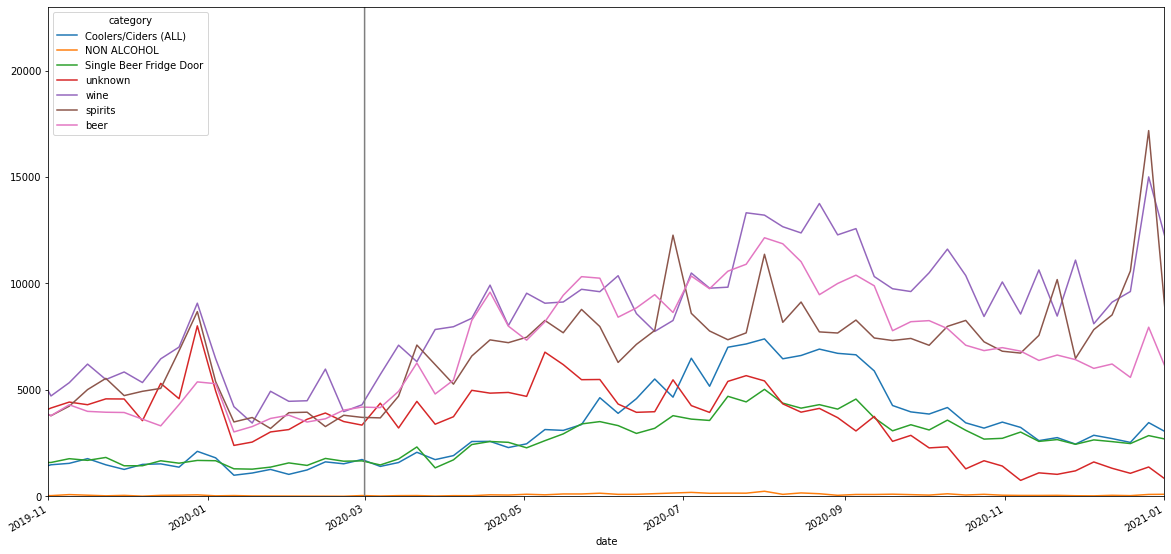

In [37]:
weeklyTotals2.plot(xlim = (datetime(2019,11,1),datetime(2021,1,1)), ylim = (0,23000))
plt.plot(np.full(len(np.arange(0,100000)),datetime(2020,3,1)),np.arange(0,100000))

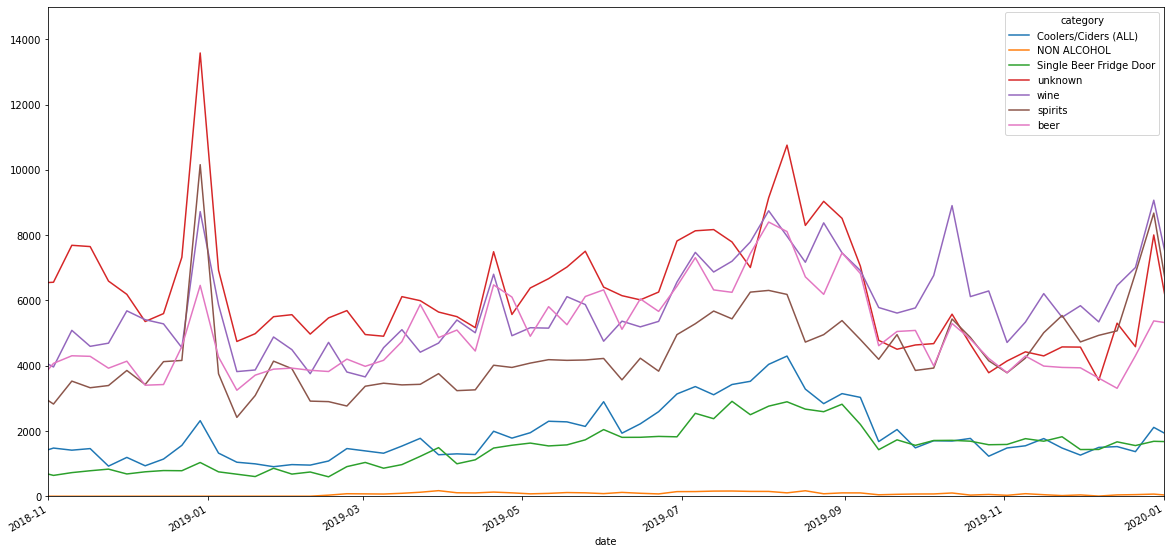

In [38]:
weeklyTotals2.plot(xlim = (datetime(2018,11,1),datetime(2020,1,1)), ylim = (0,15000))
plt.plot(np.full(len(np.arange(0,100000)),datetime(2020,3,1)),np.arange(0,100000))

(0.0, 15000.0)

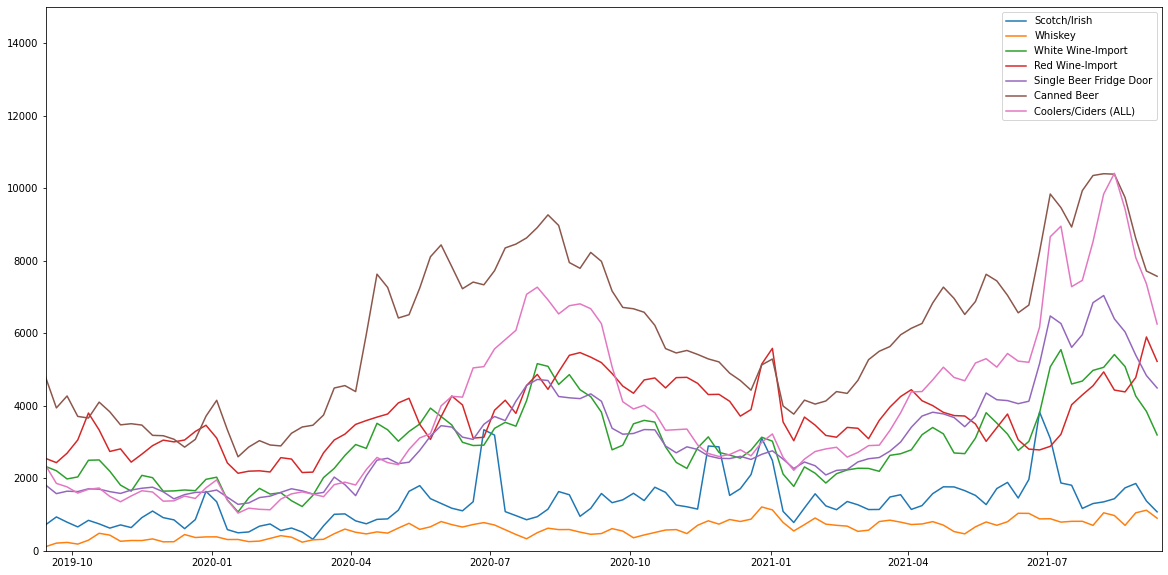

In [39]:
WeeklyTotals = pd.pivot_table(WeeklySales, values = ['units','cost','total'],index = ['date'],columns = ['category'], fill_value = 0, aggfunc = 'sum')

coarsen = 2
products = ['Scotch/Irish','Whiskey','White Wine-Import','Red Wine-Import','Single Beer Fridge Door','Canned Beer','Coolers/Ciders (ALL)']
for product in products:
    x = WeeklyTotals.index
    y = (WeeklyTotals['total'][product]).rolling(window = coarsen).mean()
    #y = WeeklyTotals['units'][product].rolling(window = coarsen).mean()
    plt.plot(x,y, label = product)
plt.legend()
plt.xlim(datetime(2019,9,14),datetime(2021,9,14))
plt.ylim(0,15000)


<AxesSubplot:xlabel='date'>

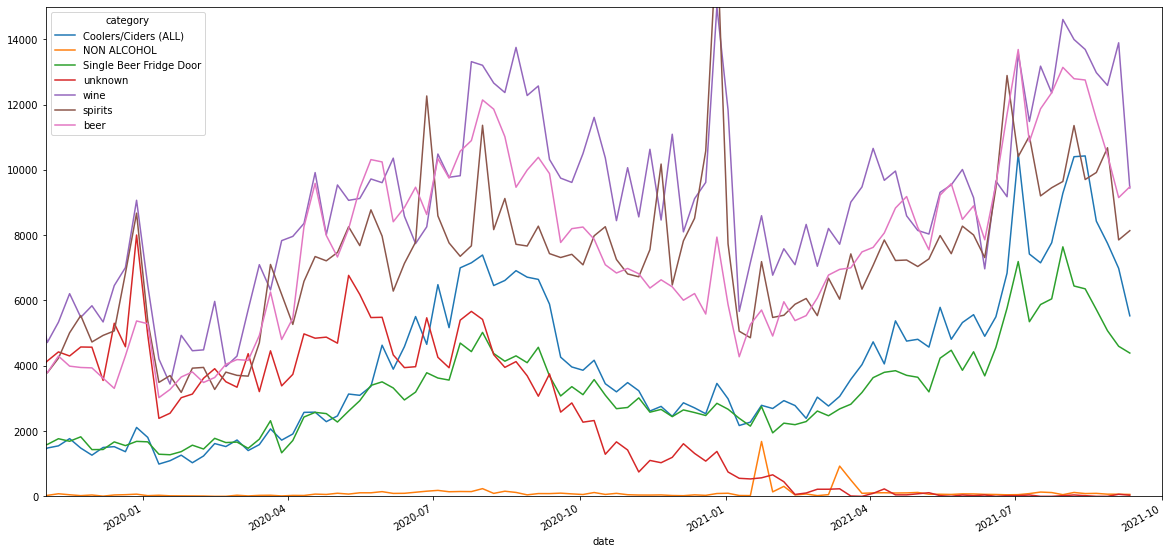

In [40]:
weeklyTotals2.plot(xlim = (datetime(2019,11,1),datetime(2021,10,1)), ylim = (0,15000))

In [41]:
itemTotals = ps.sqldf("Select name, category, AVG(unit_total) as sale_price, AVG(unit_cost) as unit_cost, AVG(unit_total) - AVG(unit_cost) as unit_profit, Sum(total)-sum(cost) AS total_profit,Sum(cost) AS total_cost,Sum(total) AS total_sales,Sum(units) AS total_units FROM WeeklySales WHERE date > \"2020-09-14\" GROUP BY upc ORDER BY Sum(units) DESC")

In [42]:
itemTotals = itemTotals.sort_values(by = 'total_sales',ascending = False)
itemTotals['average_margin'] = itemTotals['total_profit']/itemTotals['total_cost']
itemTotals.to_csv('Item Totals.csv',index = False)
itemTotals.head(20)

name              category  sale_price  \
1                  LUCKY LAGER 6AR           Canned Beer    9.404235   
4               DRIFTW FAT TUG 6AR           Canned Beer   14.254325   
8        PROVINCIAL GIN+GRAPEFRUIT  Coolers/Ciders (ALL)   13.482045   
31                LUCKY LAGER 15AR           Canned Beer   24.628469   
35                  BUDWEISER 15AR           Canned Beer   26.509924   
11              TOLLO PINOT GRIGIO     White Wine-Import   13.812653   
6                    BUDWIESER 6AR           Canned Beer   10.750389   
3                    SHAFTBURY 420           Canned Beer    8.165451   
47                    KOKANEE 15AR           Canned Beer   26.490142   
26           STONELEIGH SAUV BLANC     White Wine-Import   17.752618   
12                     KOKANEE 6AR           Canned Beer   10.545920   
17   BLACK FLY GIN FIZZ GRAPEFRUIT  Coolers/Ciders (ALL)   12.516767   
10             EXTRA OLD STOCK 6AR           Canned Beer    8.971800   
111       SCREW IT PINOT GRIGIO 4L   White Wine-Domestic   36.459718   
19       LONETREE GINGER APPLE 6AR  Coolers/Ciders (ALL)   11.521458   
25       HEY YALL HARD ICE TEA 6AR  Coolers/Ciders (ALL)   12.500626   
21      GABBIES GROOVIN GRANNY 4AR  Coolers/Ciders (ALL)   10.940694   
74        SMIRNOFF VODKA 750mL PET                 Vodka   24.248214   
91    STRAIT&NARROW ADVENTURE 12AR  Coolers/Ciders (ALL)   27.358841   
58      WHITEHAVEN SAUVIGNON BLANC     White Wine-Import   19.800066   

     unit_cost  unit_profit  total_profit  total_cost  total_sales  \
1     7.000782     2.403454     6313.1881  18220.9019     24534.09   
4    11.073847     3.180477     4949.5000  17202.3000     22151.80   
8     9.700000     3.782045     4904.2400  12745.8000     17650.04   
31   17.511983     7.116487     5003.2000  12296.0000     17299.20   
35   20.400661     6.109263     3759.9600  12674.4000     16434.36   
11    9.983621     3.829032     4520.8100  11789.7800     16310.59   
6     6.795542     3.954847     5735.9075   9955.5725     15691.48   
3     5.796491     2.368959     4421.3400  10659.8000     15081.14   
47   20.407925     6.082217     3130.2400  10484.1600     13614.40   
26   13.101273     4.651346     3569.7200   9984.4000     13554.12   
12    7.085154     3.460766     4097.0213   8318.6387     12415.66   
17    9.834762     2.682005     2442.3600   8947.4000     11389.76   
10    6.389076     2.582724     3179.0800   7880.6800     11059.76   
111  25.470392    10.989326     3151.4100   7334.1900     10485.60   
19    8.264987     3.256472     2710.5700   7225.5800      9936.15   
25    9.073602     3.427024     2636.3600   6963.5400      9599.90   
21    8.001484     2.939211     2494.8200   6773.3800      9268.20   
74   18.064680     6.183534     2375.2600   6863.8400      9239.10   
91   20.237019     7.121822     2321.5900   6657.5600      8979.15   
58   13.733994     6.066072     2661.9700   6188.7500      8850.72   

     total_units  average_margin  
1           2607        0.346481  
4           1554        0.287723  
8           1314        0.384773  
31           702        0.406897  
35           620        0.296658  
11          1181        0.383452  
6           1460        0.576150  
3           1847        0.414768  
47           514        0.298569  
26           764        0.357530  
12          1157        0.492511  
17           910        0.272969  
10          1232        0.403402  
111          287        0.429688  
19           861        0.375135  
25           768        0.378595  
21           847        0.368327  
74           381        0.346054  
91           329        0.348715  
58           447        0.430130

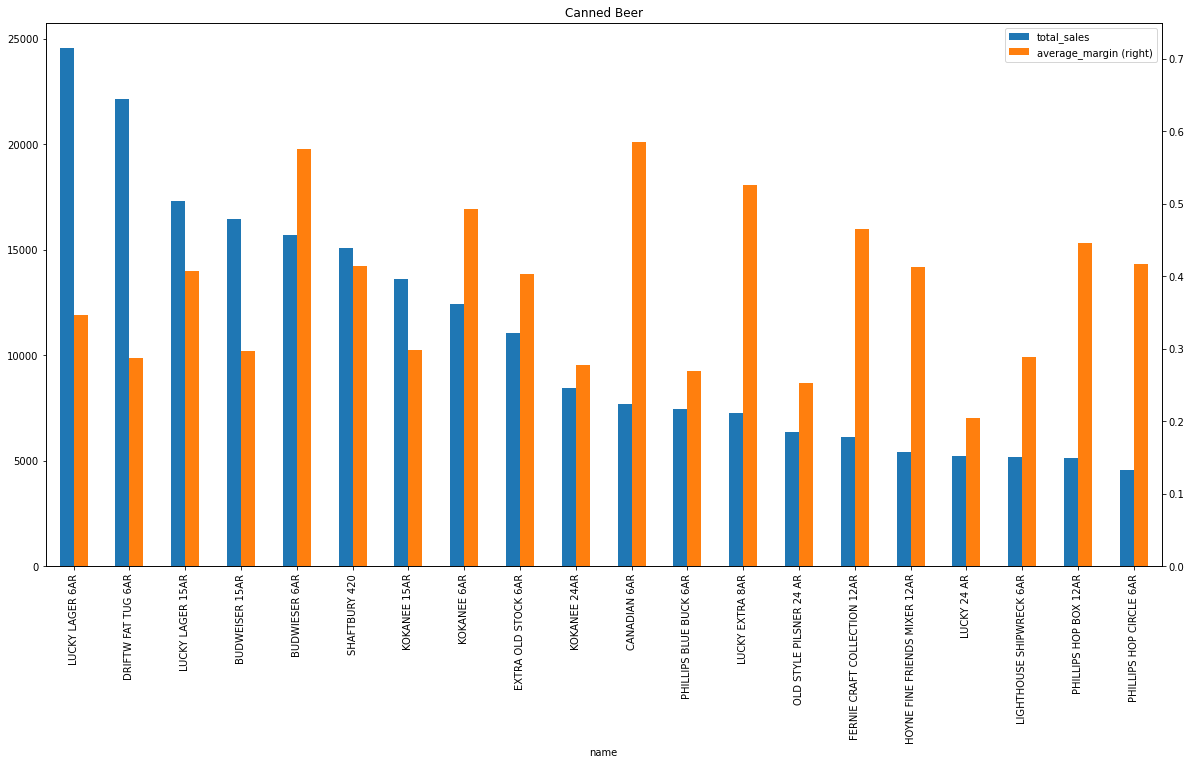

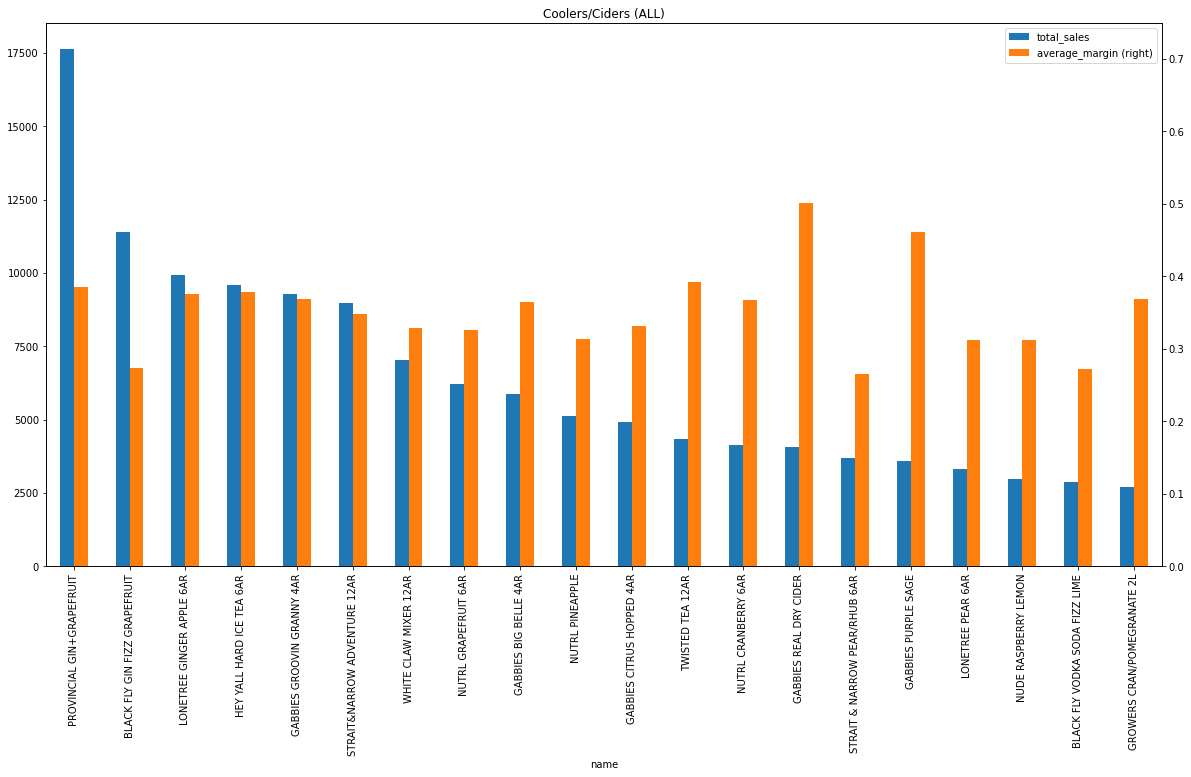

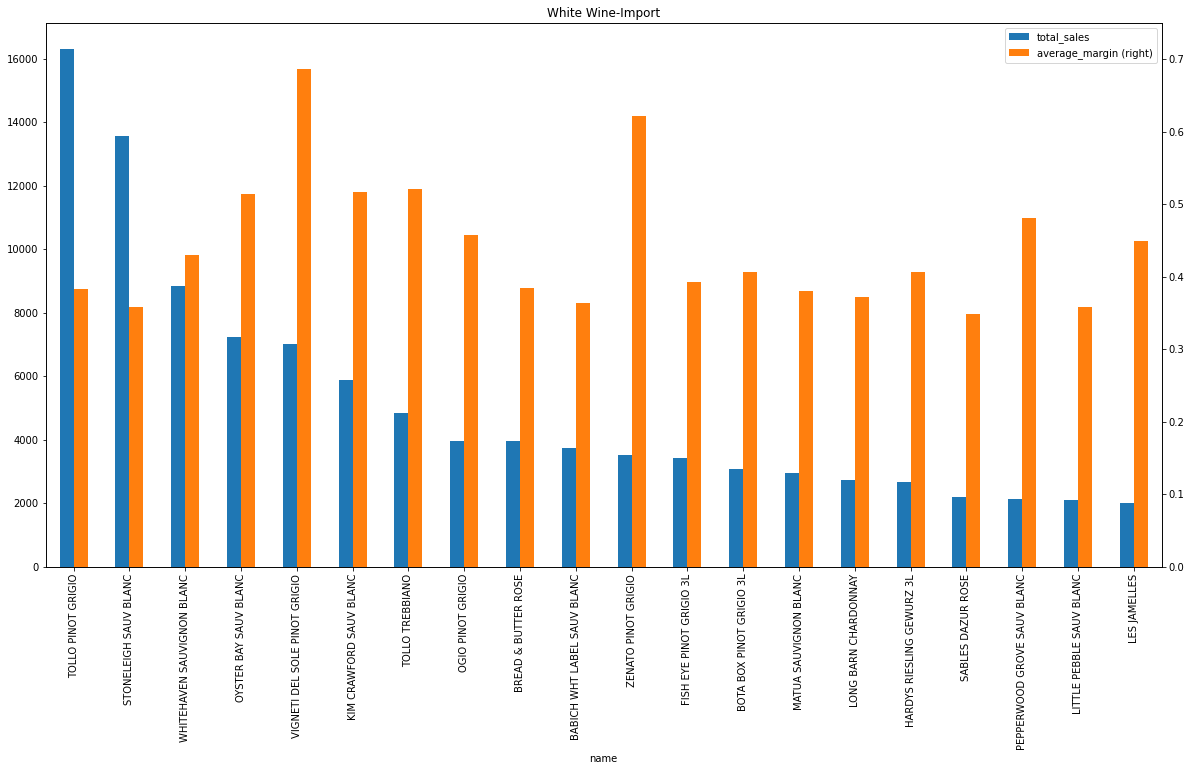

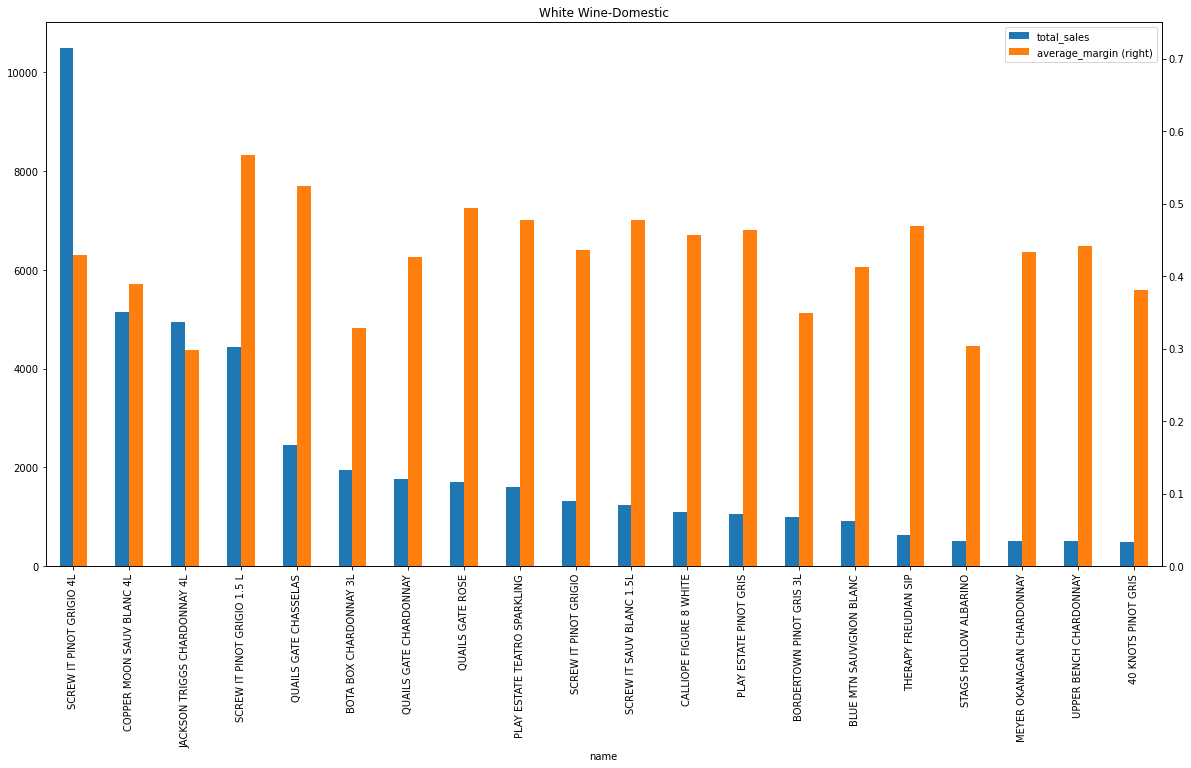

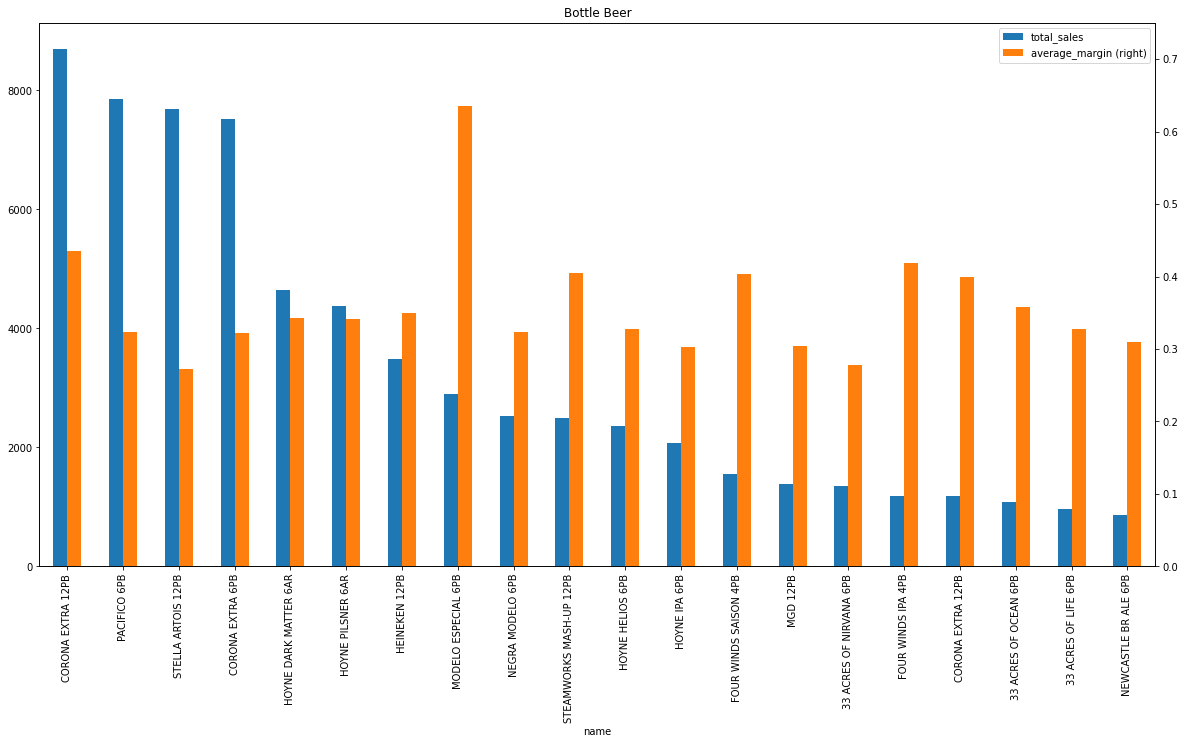

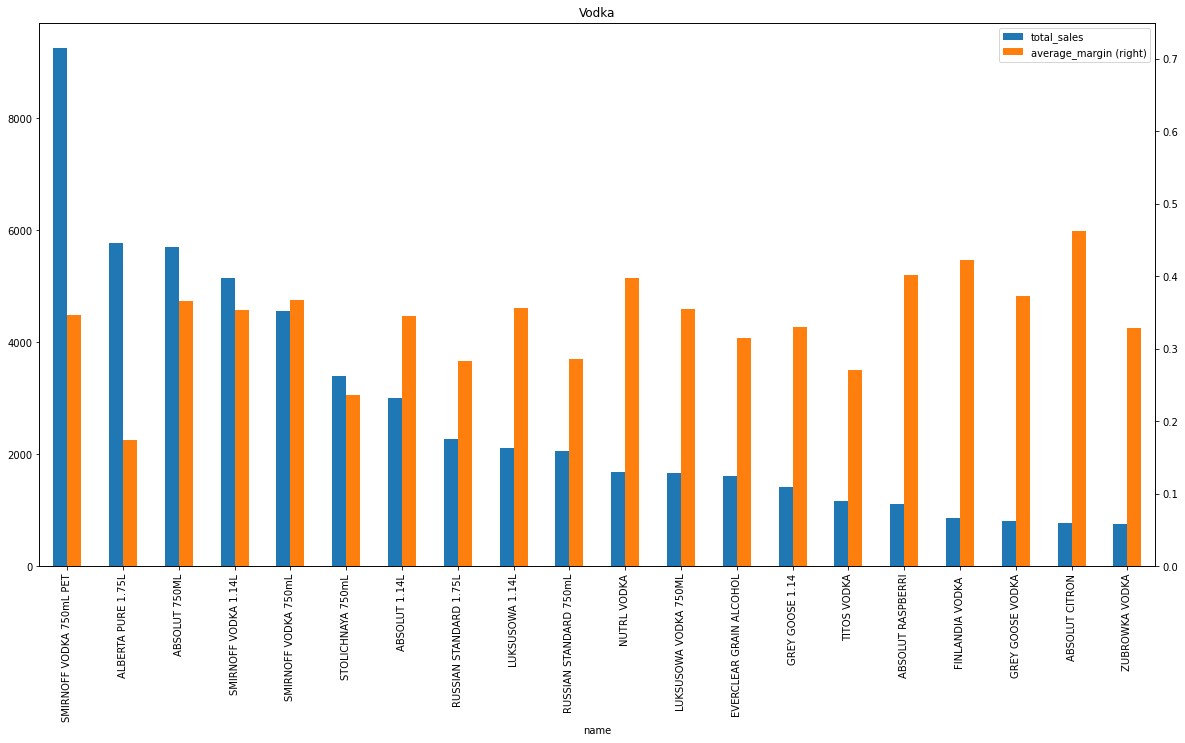

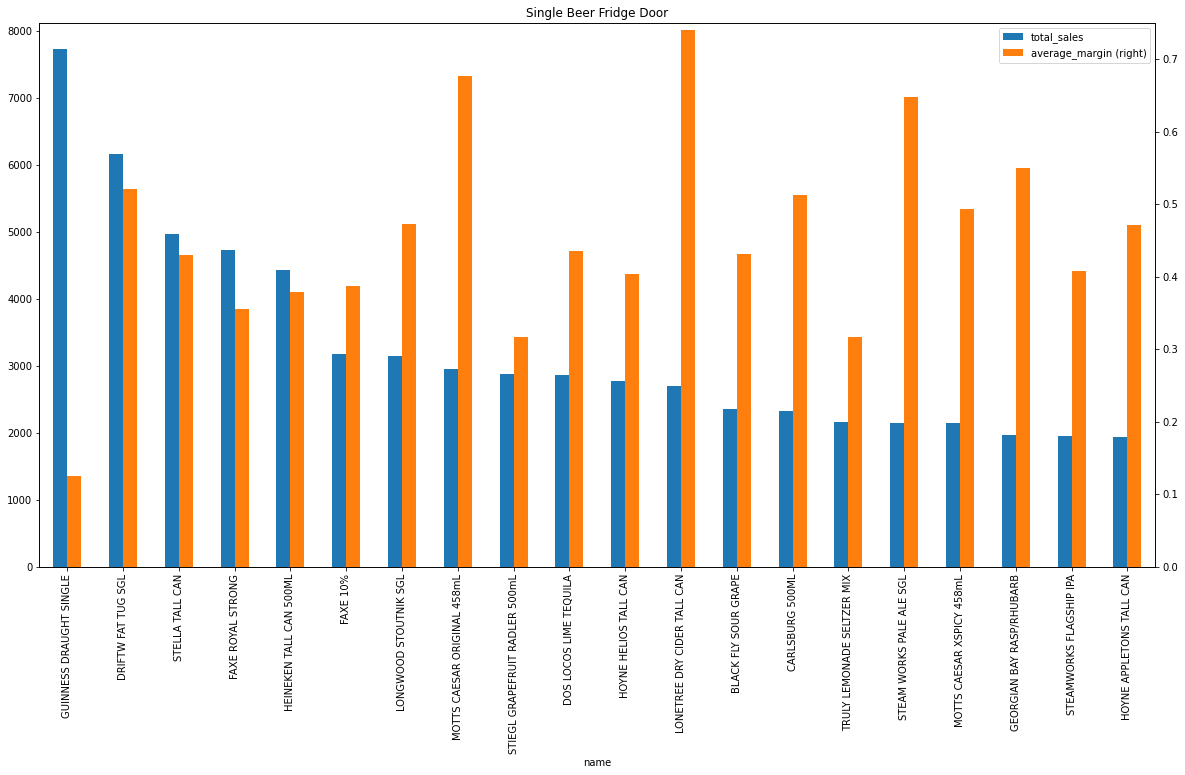

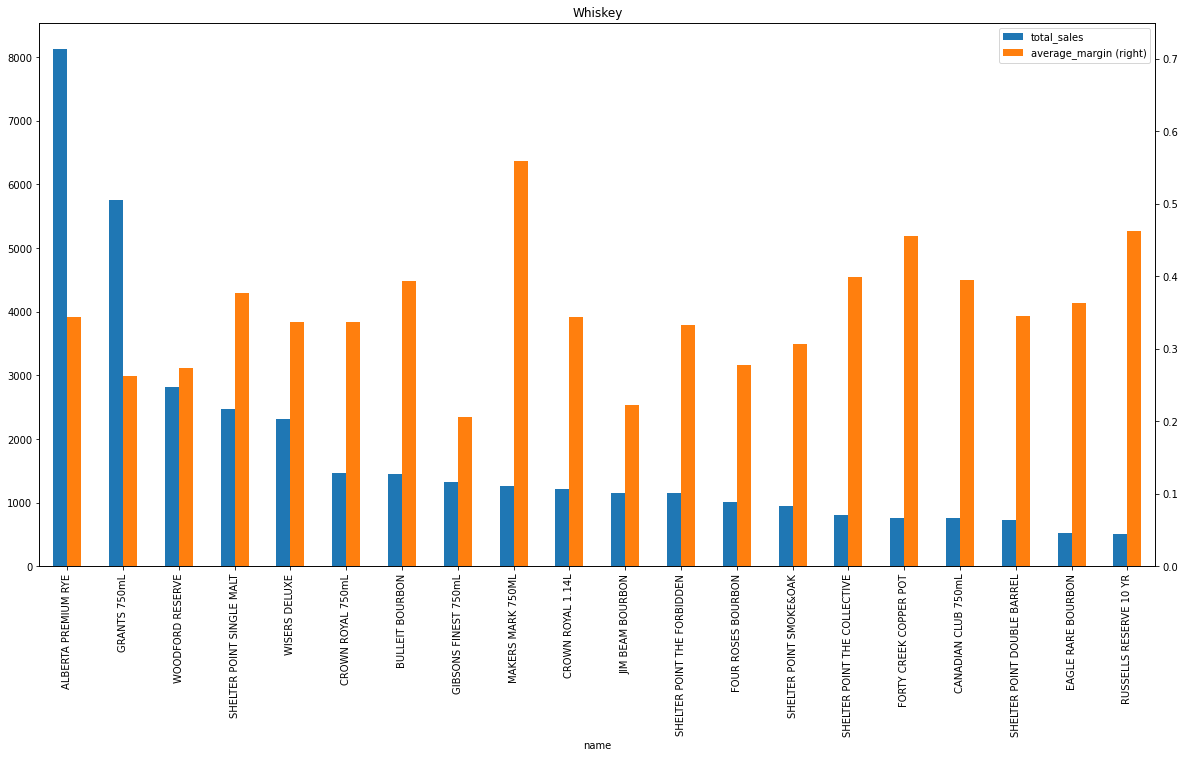

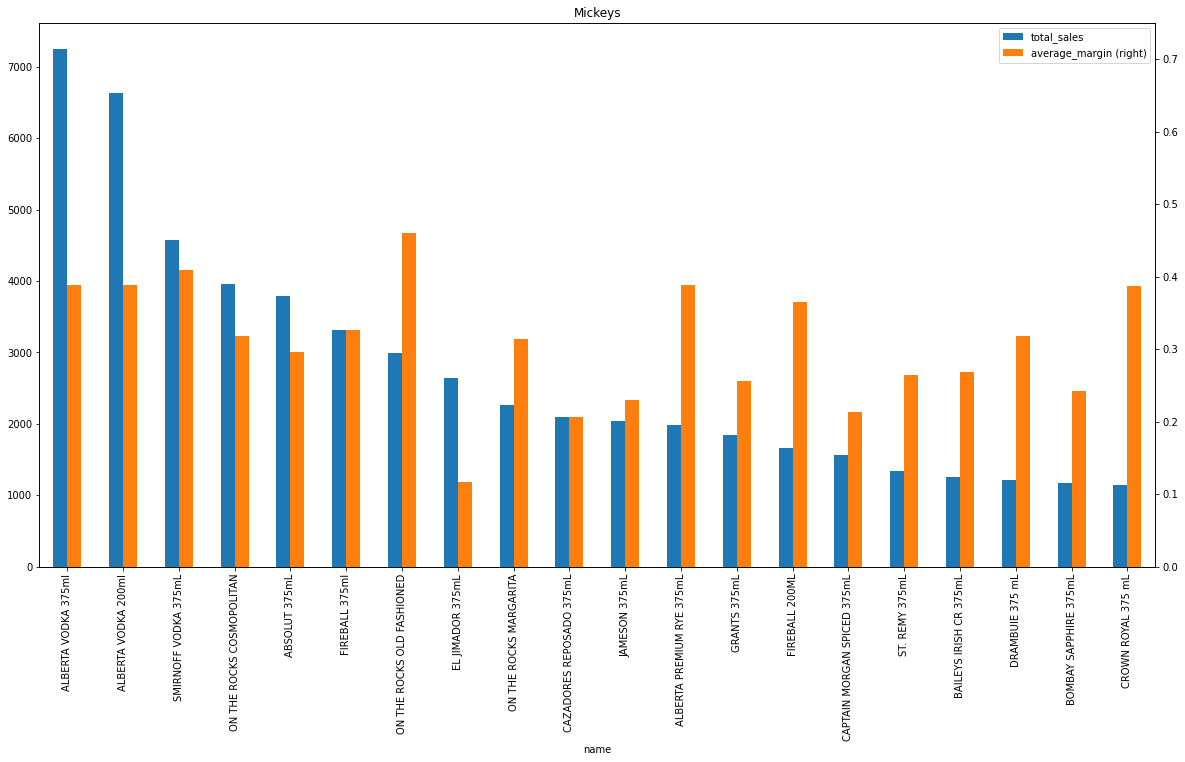

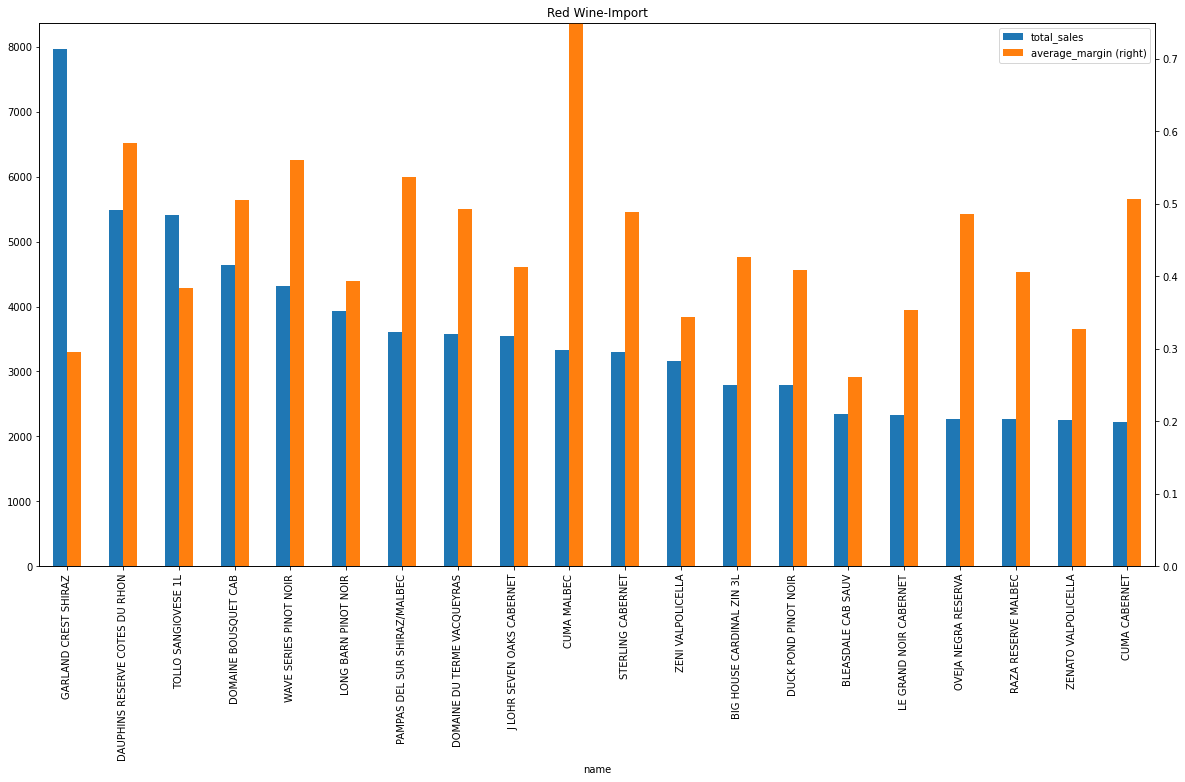

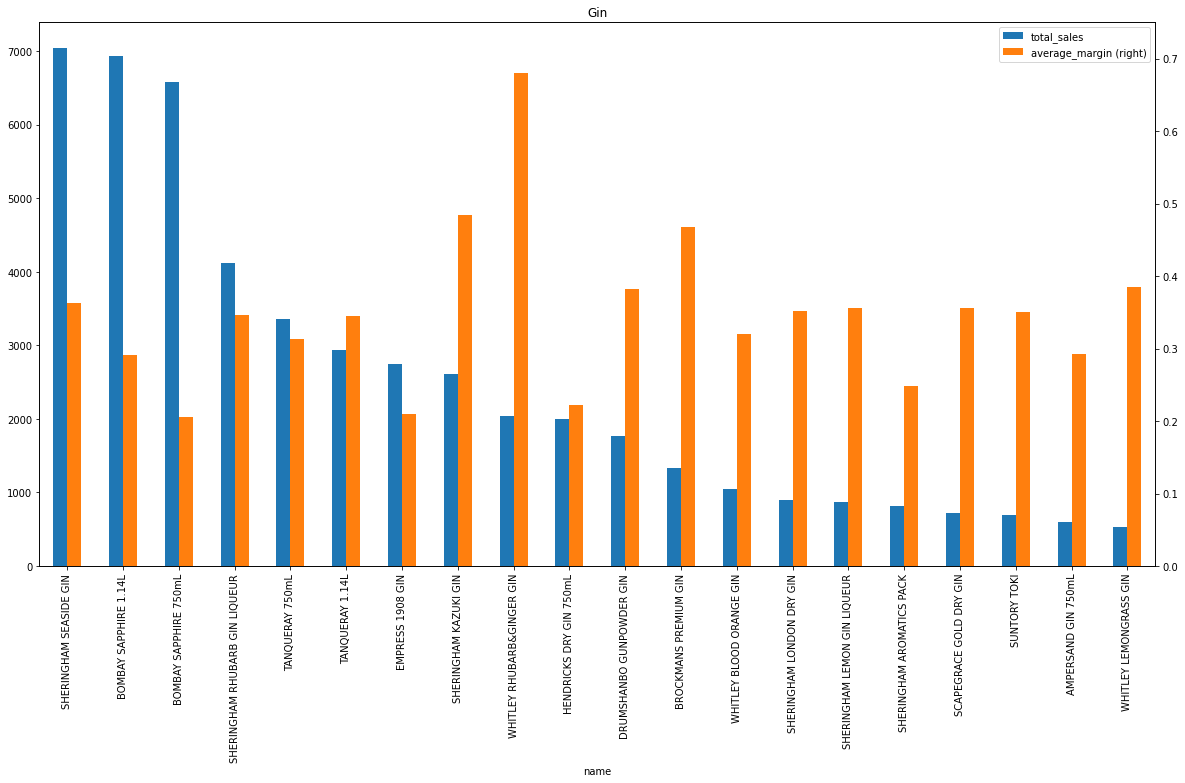

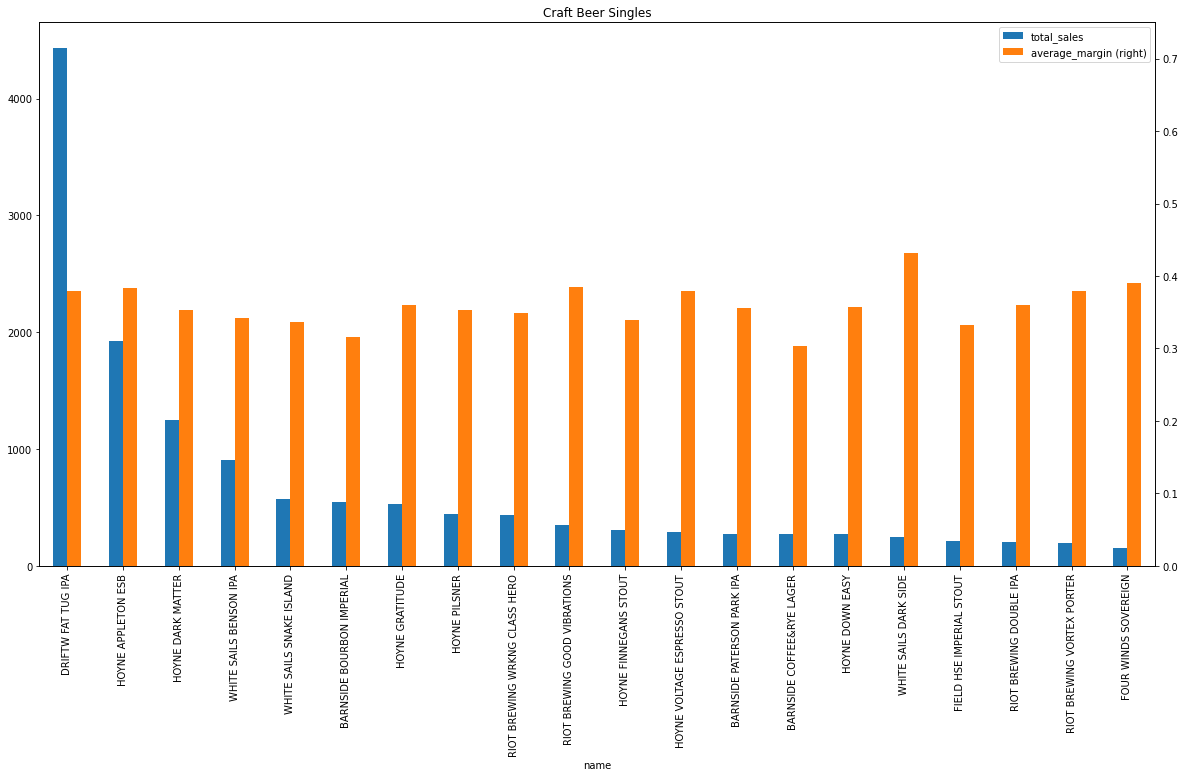

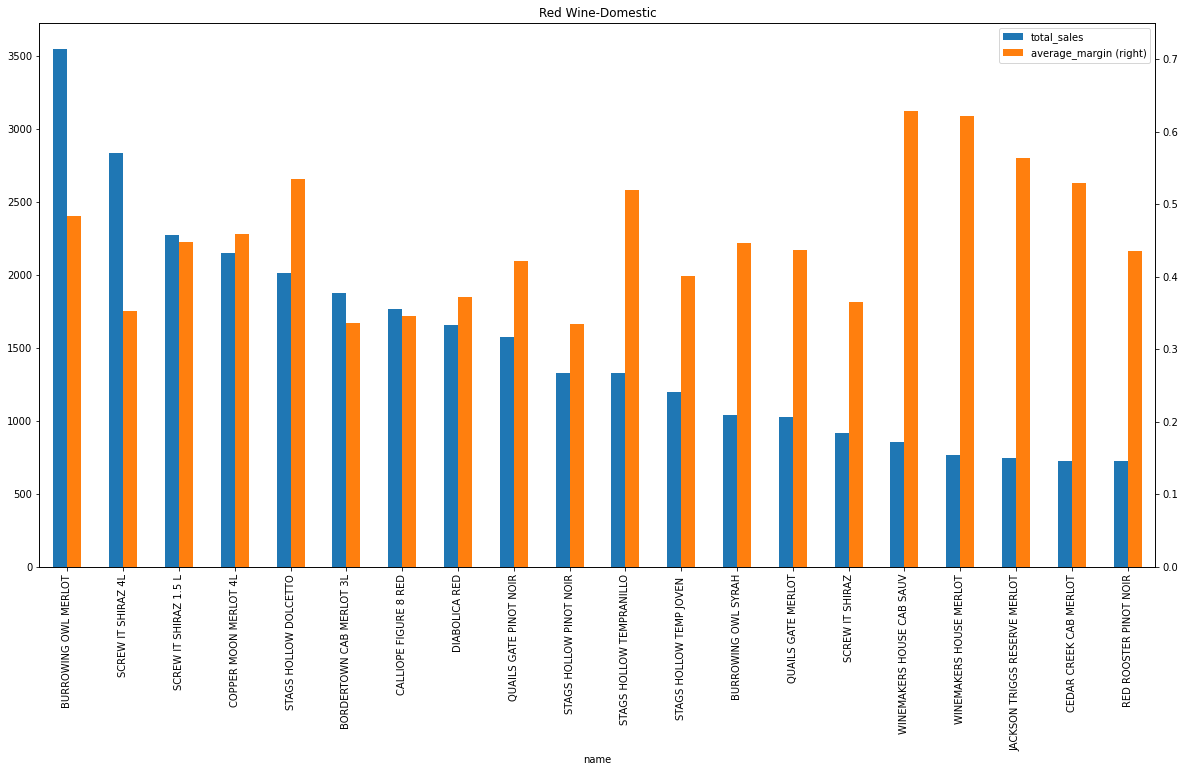

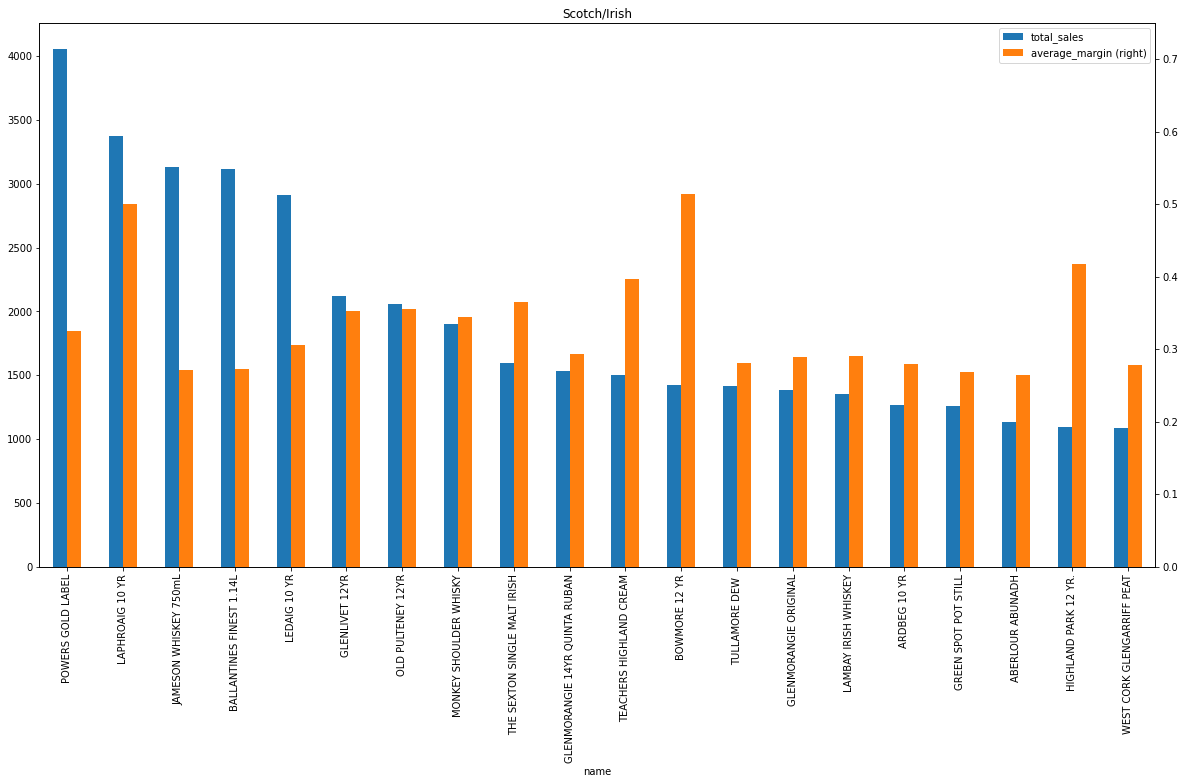

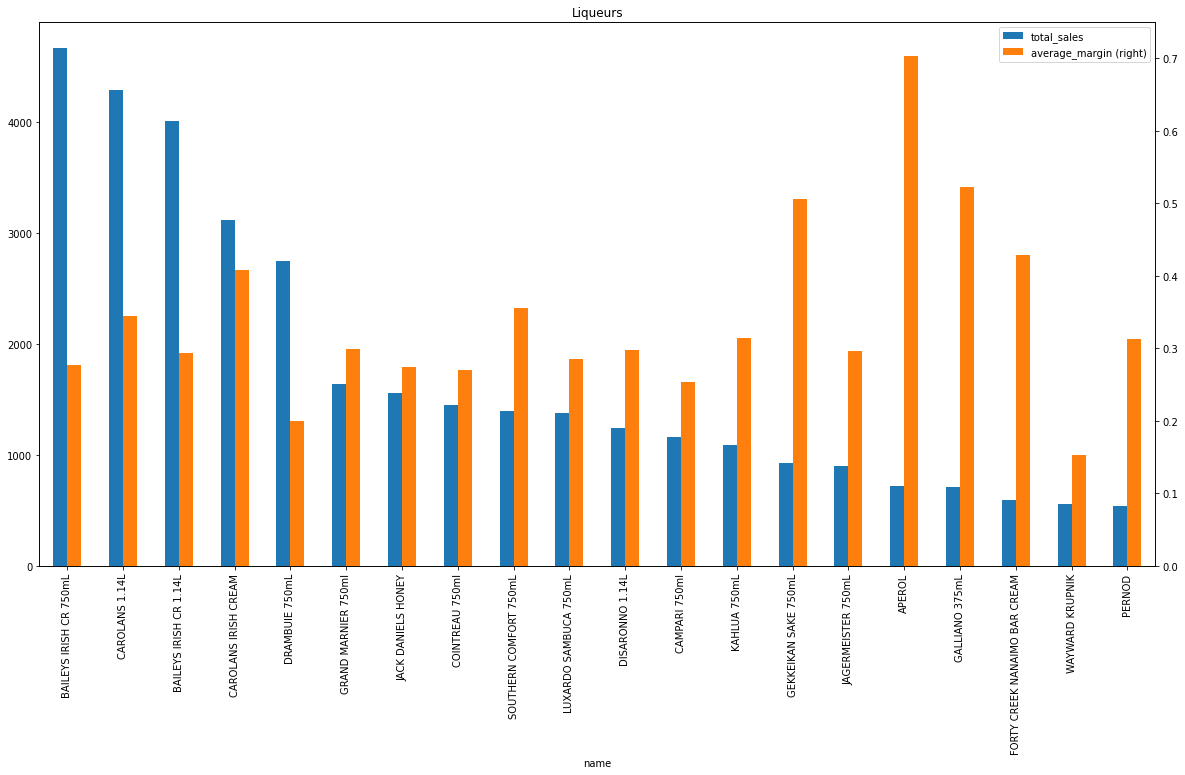

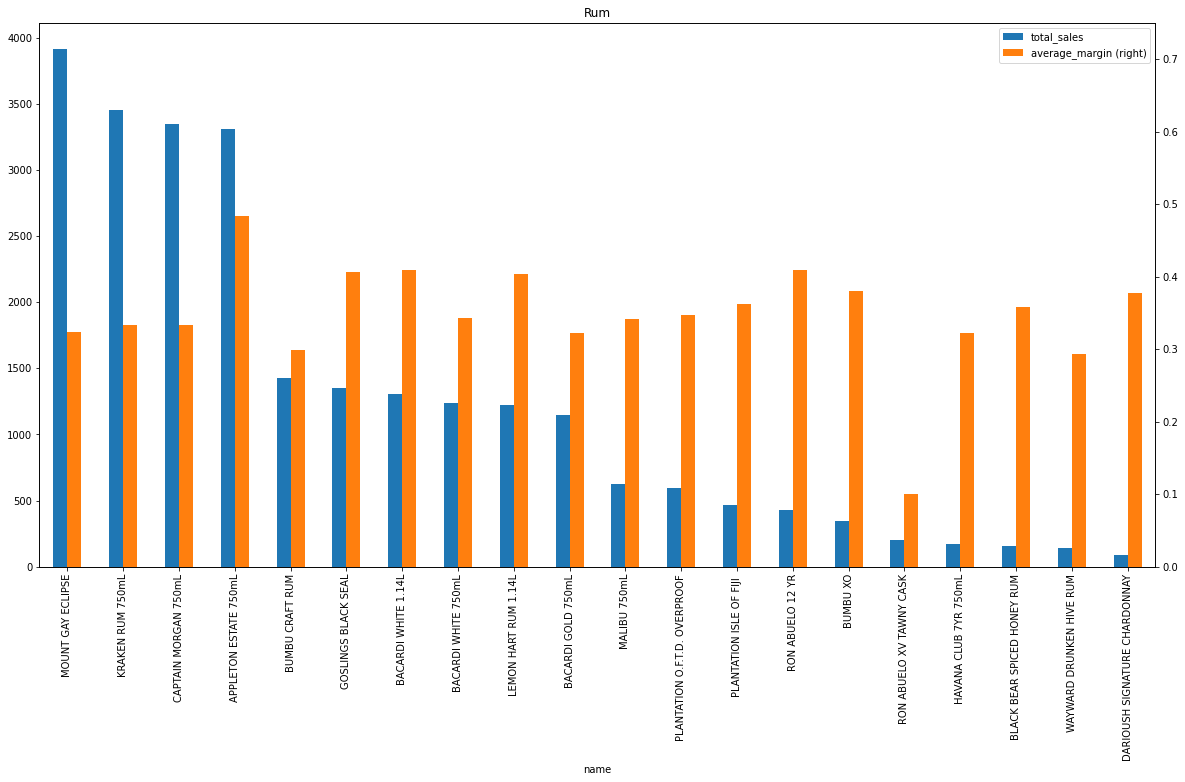

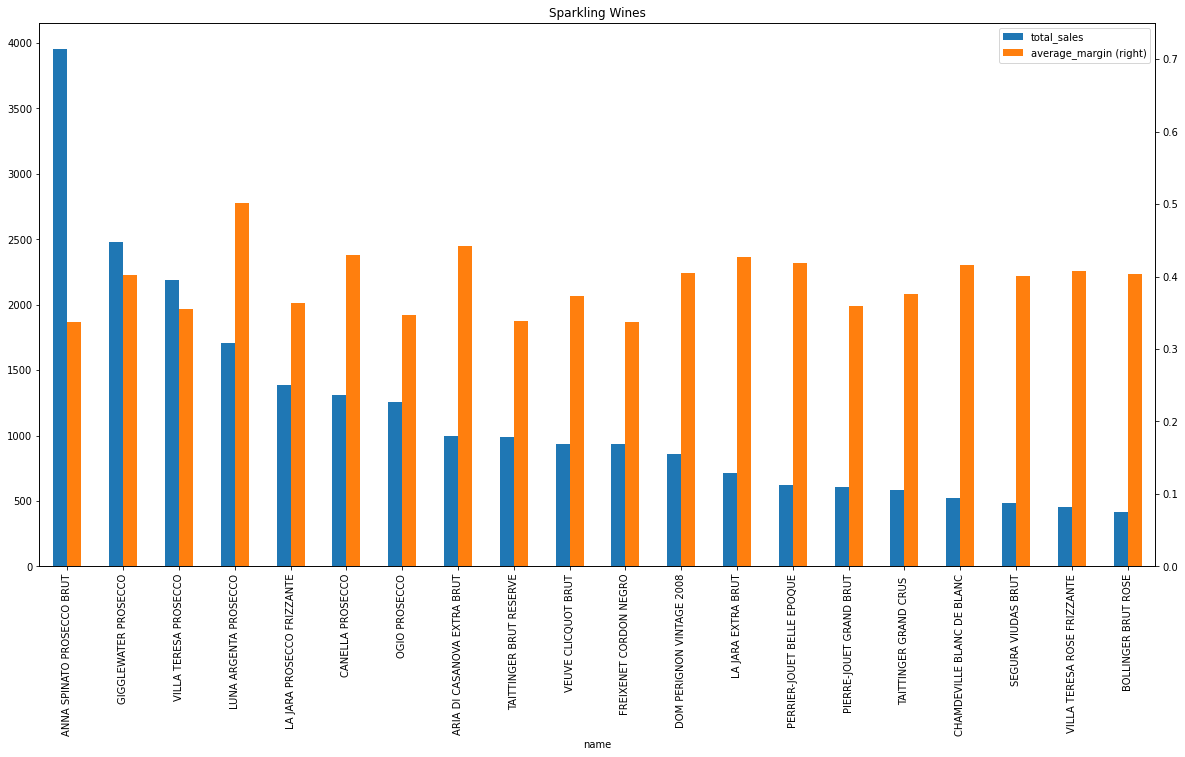

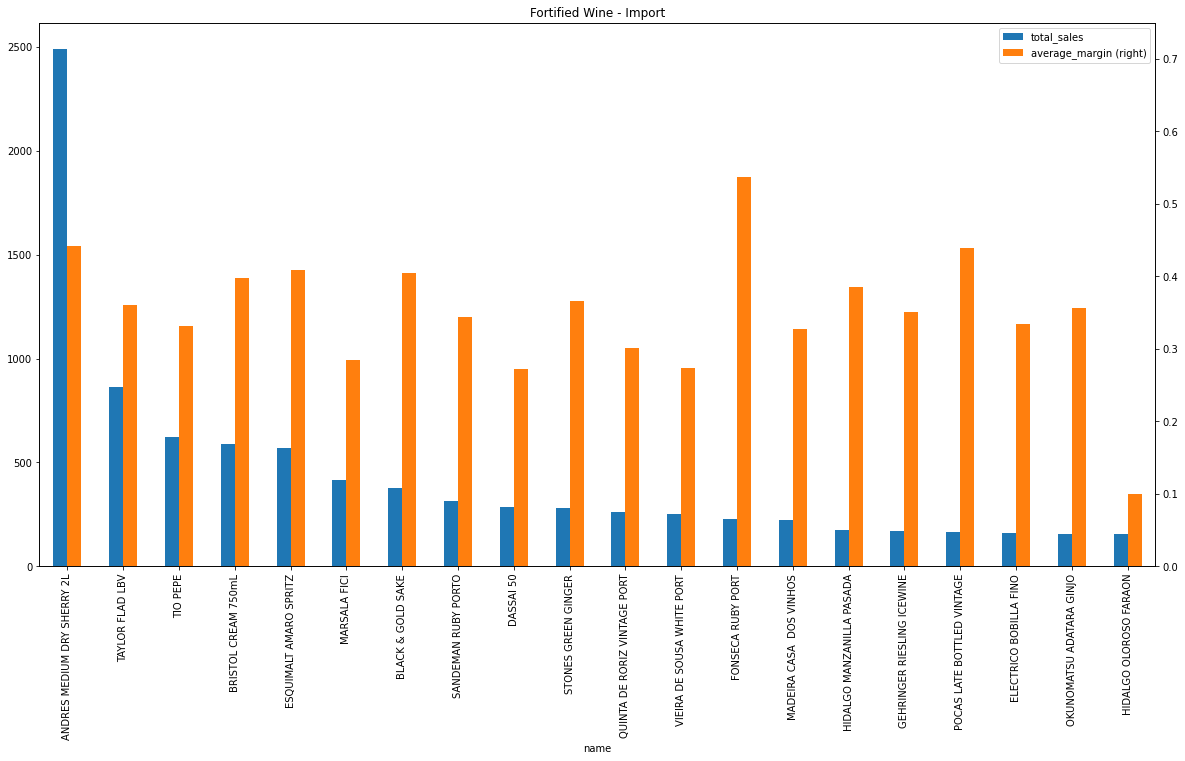

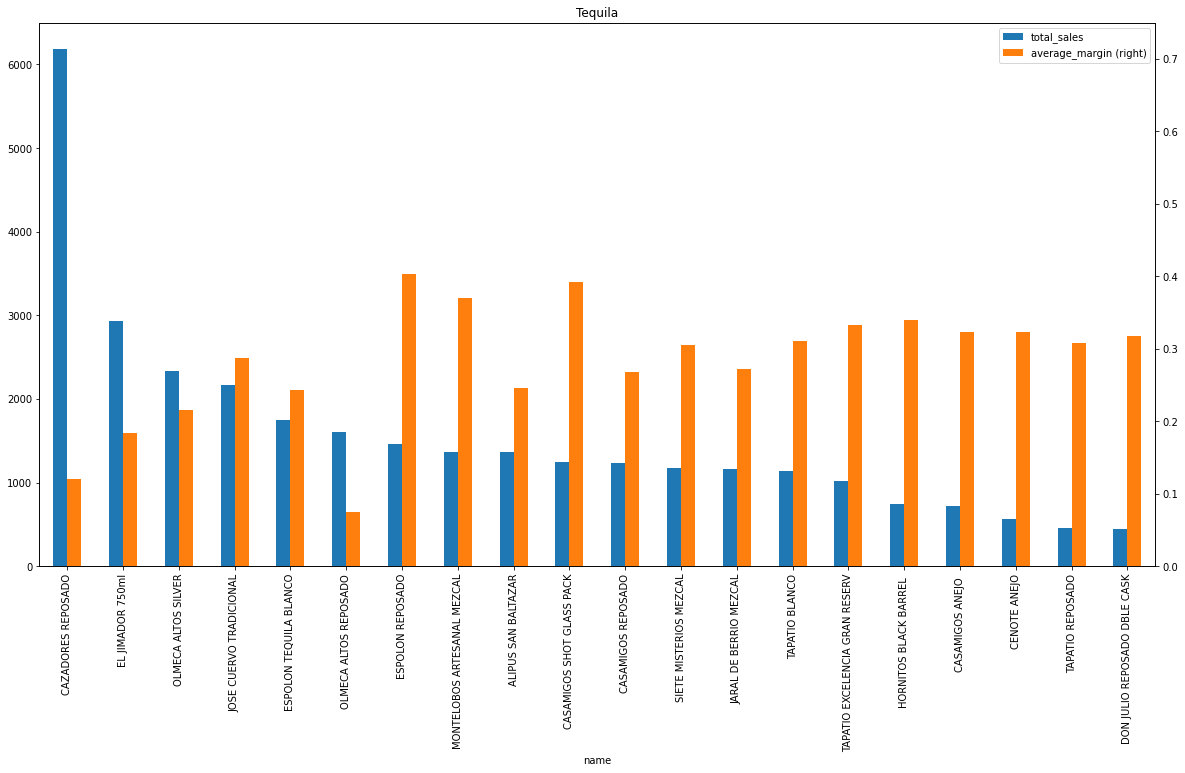

In [43]:
#categories = itemTotals['category'].unique()
#print(categories)
categories = ['Canned Beer', 'Coolers/Ciders (ALL)', 'White Wine-Import',
 'White Wine-Domestic', 'Bottle Beer', 'Vodka', 'Single Beer Fridge Door',
 'Whiskey', 'Mickeys', 'Red Wine-Import', 'Gin', 'Craft Beer Singles',
 'Red Wine-Domestic', 'Scotch/Irish', 'Liqueurs', 'Rum', 'Sparkling Wines',
 'Fortified Wine - Import', 'Tequila']
for cat in categories:
    ax = itemTotals[itemTotals['category'] == cat][:20].plot.bar(y=['total_sales','average_margin'],x='name',secondary_y = 'average_margin')
    ax.right_ax.set_ylim(0,0.75)
    plt.title(cat)


In [44]:
categoryTotals = itemTotals.groupby('category').sum()[['total_profit','total_sales','total_units','total_cost']]
categoryTotals['average_margin'] = categoryTotals['total_profit']/categoryTotals['total_cost']
categoryTotals.sort_values(by = 'total_profit', ascending = False)

total_profit  total_sales  total_units   total_cost  \
category                                                                       
Canned Beer                89599.4619    339929.97        24678  250330.5081   
Red Wine-Import            66434.1400    209050.70        11340  142616.5600   
Coolers/Ciders (ALL)       64560.9100    245203.54        19194  180642.6300   
Single Beer Fridge Door    61350.4757    192824.69        54237  131474.2143   
White Wine-Import          50284.7700    166275.45         9039  115990.6800   
Scotch/Irish               19642.3100     84926.95         1219   65284.6400   
Bottle Beer                18479.3600     70760.66         4114   52281.3000   
Mickeys                    18236.4500     75641.95         6501   57405.5000   
White Wine-Domestic        15776.1100     52969.75         2092   37193.6400   
Vodka                      14285.6600     58583.97         1886   44298.3100   
Gin                        13200.5000     53987.89         1365   40787.3900   
Red Wine-Domestic          13078.3100     43605.59         1695   30527.2800   
Liqueurs                   10116.5800     41840.36         1454   31723.7800   
Whiskey                     9739.3800     39761.36         1166   30021.9800   
Sparkling Wines             8898.8268     31561.62         1479   22662.7932   
unknown                     8068.6260     29182.70         2021   21114.0740   
Tequila                     6611.9900     34030.03          741   27418.0400   
Rum                         6599.5300     24933.90          779   18334.3700   
Craft Beer Singles          3863.3100     14503.57         2021   10640.2600   
Fortified Wine - Import     2643.0800      9942.94          460    7299.8600   
NON ALCOHOL                 1632.2843      6795.58          977    5163.2957   
Brandy                      1401.0200      5806.07          163    4405.0500   
Wine Accessories             108.4400      2782.63          461    2674.1900   

                         average_margin  
category                                 
Canned Beer                    0.357925  
Red Wine-Import                0.465823  
Coolers/Ciders (ALL)           0.357396  
Single Beer Fridge Door        0.466635  
White Wine-Import              0.433524  
Scotch/Irish                   0.300872  
Bottle Beer                    0.353460  
Mickeys                        0.317678  
White Wine-Domestic            0.424161  
Vodka                          0.322488  
Gin                            0.323642  
Red Wine-Domestic              0.428414  
Liqueurs                       0.318896  
Whiskey                        0.324408  
Sparkling Wines                0.392662  
unknown                        0.382144  
Tequila                        0.241155  
Rum                            0.359954  
Craft Beer Singles             0.363084  
Fortified Wine - Import        0.362073  
NON ALCOHOL                    0.316132  
Brandy                         0.318049  
Wine Accessories               0.040551

In [45]:
for cat in list(categoryTotals.index):
    itemTotals.loc[itemTotals['category'] == cat,'margin_variance'] = itemTotals.loc[itemTotals['category'] == cat,'average_margin'] - categoryTotals.loc[cat,'average_margin']
itemTotals.drop(itemTotals[itemTotals['total_units']<5].index, inplace = True)
itemTotals.sort_values(by = 'margin_variance').head(50)


name                 category  sale_price  \
0           GUINNESS DRAUGHT SINGLE  Single Beer Fridge Door    2.768062   
596         ST PATRICKS DAY SAMPLER              NON ALCOHOL   42.857143   
699   FERNIE TIMELAPSE HELLES LAGER  Single Beer Fridge Door    3.030003   
346           SOUTH SIDE SINGLE CAN     Coolers/Ciders (ALL)    4.791250   
939        DU CLAW SWEET BABY JESUS  Single Beer Fridge Door    4.440000   
1383      TASCA REGALEALI CABERNET           Red Wine-Import   61.331000   
1007       VIEVITE ROSE DE PROVENCE        White Wine-Import   23.187500   
784          GROUNDBREAKER DARK ALE  Single Beer Fridge Door    5.976190   
1438   LOUIS MICHEL & FILS VAILLONS        White Wine-Import   37.920000   
1472         HIDALGO OLOROSO FARAON  Fortified Wine - Import   31.000000   
1470                   HIDALGO FINO  Fortified Wine - Import   22.500000   
842            R&B ALWAYS SUNNY SGL  Single Beer Fridge Door    4.015444   
831             4 MESES JUMILLA RED          Red Wine-Import   17.300000   
1293   TORNATORE PIETRARIZZO BIANCO        White Wine-Import   43.306667   
853                  LA POSTA TINTO          Red Wine-Import   18.839474   
274              BLEASDALE CAB SAUV          Red Wine-Import   18.250794   
1328       SOUTH SIDE CRANBERRY 6AR     Coolers/Ciders (ALL)    6.667778   
221                EL JIMADOR 375mL                  Mickeys   17.000000   
861   CHATEAU LA MAROUTINE BORDEAUX        White Wine-Import   17.770000   
1107     PERSEPHONE CHERRY SOUR ALE  Single Beer Fridge Door    5.107188   
1371          CUPCAKE RED VELVET 3L          Red Wine-Import   49.785000   
687           BLACK BOX CAB SAUV 3L          Red Wine-Import   35.864222   
337           BAILEYS IRISH CR 50mL                  Mickeys    3.388561   
1523          KETEL ONE VODKA 1.14L                    Vodka   42.226667   
1320             TOFANELLI GRENACHE          Red Wine-Import   43.685200   
1478        CASA ERMELINDA TINTO 3L          Red Wine-Import   32.192500   
1348                        unknown                  unknown    6.000000   
873            BOTA BOX CABERNET 3L          Red Wine-Import   36.667500   
1164            CASTANO MONASTRELL           Red Wine-Import   12.520000   
635          CYCLES PINOT NOIR CAN           Red Wine-Import    9.993103   
1512               SAGE HILLS SYRAH        Red Wine-Domestic   56.430000   
56      STIEGL ZITRONE RADLER 500mL  Single Beer Fridge Door    3.388455   
1167       PRUNUS PRIVATE SELECTION          Red Wine-Import   24.292222   
962     VILLA MARIA SAUVIGNON BLANC        White Wine-Import   16.430000   
16             GARLAND CREST SHIRAZ          Red Wine-Import    8.610000   
228      LONGWOOD CITRA DRAGON HAZY  Single Beer Fridge Door    4.246615   
703           OLMECA ALTOS REPOSADO                  Tequila   36.430000   
373          MARGARITAVILLE CLASSIC  Single Beer Fridge Door    3.900000   
1093                WAYWARD KRUPNIK                 Liqueurs   30.353750   
1423           ESPORAO TRINCADEIRA           Red Wine-Import   25.894444   
1392     MEYER TRIBUTE SERIES CHARD      White Wine-Domestic   32.052000   
827            CANELLA BELLINI MINI  Single Beer Fridge Door    7.060000   
912    PROVINCIAL CUCMBER SUMAC GIN  Single Beer Fridge Door    5.011905   
753    SHERINGHAM SEASIDE GIN 375mL                  Mickeys   23.194261   
1287      BLACK BOX PINOT GRIGIO 3L        White Wine-Import   36.078750   
1488             LES TERRES ROSE 3L        White Wine-Import   59.464000   
1414    HENSCHKE KEYNETON EUPHONIUM          Red Wine-Import   86.706000   
215                     LUCKY 24 AR              Canned Beer   32.416224   
933             YELLOW TAIL BUBBLES          Sparkling Wines   15.127500   
352              SUPERFLUX COCONUTS  Single Beer Fridge Door    4.690000   

      unit_cost  unit_profit  total_profit  total_cost  total_sales  \
0      2.447028     0.321034      857.1300   6874.0300      7731.16   
596   42.857

AxesSubplot(0.125,0.125;0.775x0.755)


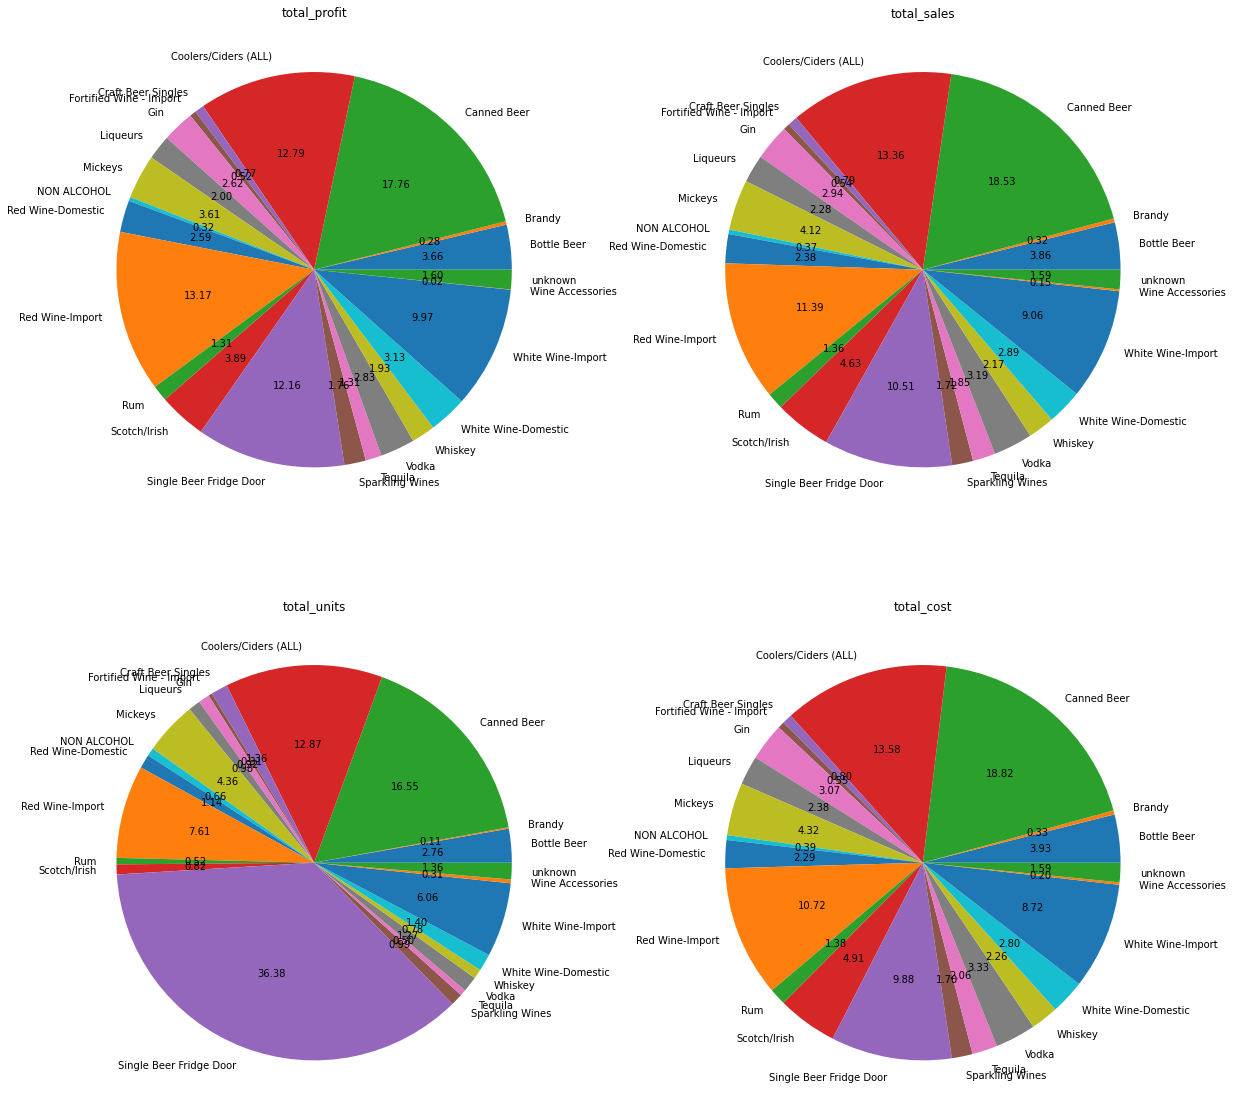

In [46]:
fig, axes = plt.subplots(2,2,figsize = (20,20))
print(ax)
for ax, col in zip(fig.axes, categoryTotals.columns):
    categoryTotals[col].plot.pie(autopct = '%.2f', fontsize = 10, ax = ax)
    ax.set_ylabel('')
    ax.set_title(str(col))